# Figure 4

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import warnings
import os
import functools
import upsetplot

warnings.filterwarnings('ignore')
plt.rc('font', family='Helvetica')

# Frequency analysis

In [119]:
c_type = pd.read_csv('cancer_type_counts_per_guide.csv')
total_counts = np.sum(c_type[c_type.columns[:-1]], axis=1)

count_muts = pd.DataFrame(dict(zip(['gRNA_id', 'mutation_count'], [c_type['gRNA_id'], total_counts])))

master = pd.read_csv('master_table_min50_control_mean_invitro.csv')
master_targ = master[(master['classification']=='targeting guide') & (master['legacy']==False)]

m1 = pd.merge(master_targ, count_muts, on='gRNA_id')
#exclude mutations with indexing issues
m1 = m1[m1['mutation_count']!=0]

In [120]:
cosmic = pd.read_csv('source_data/Census_allSun Nov 17 02_26_47 2024.csv').fillna('Undefined')

#MBES = pd.read_csv('MBESv2_CORRECTED.csv')

t_dict = {'TSG':'TSG', 'TSG, fusion':'TSG', 'Undefined':'Undefined', 'fusion':'Undefined', 'oncogene':'Oncogene',
       'oncogene, TSG':'Oncogene/TSG', 'oncogene, TSG, fusion':'Oncogene/TSG', 'oncogene, fusion': 'Oncogene'}

gene_type = []
for i, val in m1.iterrows():
    v = val['gene_name_h']
    subset = cosmic[cosmic['Gene Symbol']==v]
    if len(subset)==0:
        gene_type.append('Undefined')
    else:
        v2 = subset['Role in Cancer'].values[0]

        gene_type.append(t_dict[v2])

m1['Role in Cancer']=gene_type

In [121]:
u, c= np.unique(m1['gene_name_m'], return_counts=True)
dd = pd.DataFrame(dict(zip(['gene', 'count'], [u,c]))).sort_values(by='count', ascending=False)
top_genes = list(dd[dd['count']>=40]['gene'])

edit_cutoff = 20

corr_spleen = []
corr_iv = []
corr_bone = []
corr_men = []
num_gRNAs = []

for i in top_genes:

    
    m2 = m1[(m1['gene_name_m']==i) & (m1['target_base_edit_perc']>=edit_cutoff)] #.sort_values(by='LFC_Bone', ascending=False).reset_index(drop=True)
    x,y = m2['mutation_count'], m2['LFC_Bone']
    ff = scipy.stats.pearsonr(x,y).statistic
    corr_bone.append(ff)

    num_gRNAs.append(len(m2))

    m2 = m1[(m1['gene_name_m']==i) & (m1['target_base_edit_perc']>=edit_cutoff)] #.sort_values(by='LFC_Bone', ascending=False).reset_index(drop=True)
    x,y = m2['mutation_count'], m2['LFC_Spleen']
    ff = scipy.stats.pearsonr(x,y).statistic
    corr_spleen.append(ff)

    m2 = m1[(m1['gene_name_m']==i) & (m1['target_base_edit_perc']>=edit_cutoff)] #.sort_values(by='LFC_Bone', ascending=False).reset_index(drop=True)
    x,y = m2['mutation_count'], m2['LFC_In Vitro D15']
    ff = scipy.stats.pearsonr(x,y).statistic
    corr_iv.append(ff)

    m2 = m1[(m1['gene_name_m']==i) & (m1['target_base_edit_perc']>=edit_cutoff)] #.sort_values(by='LFC_Bone', ascending=False).reset_index(drop=True)
    x,y = m2['mutation_count'], m2['LFC_Meninges']
    ff = scipy.stats.pearsonr(x,y).statistic
    corr_men.append(ff)


corr_df = pd.DataFrame(dict(zip(['gene', 'num_gRNAs', 'corr_iv', 'corr_spleen', 'corr_bone', 'corr_men'], [top_genes, num_gRNAs, corr_iv, corr_spleen, corr_bone, corr_men])))

cos = m1[['gene_name_m', 'Role in Cancer',]].drop_duplicates().rename(columns = {'gene_name_m':'gene'})
corr_df2 = pd.merge(corr_df, cos, on='gene')

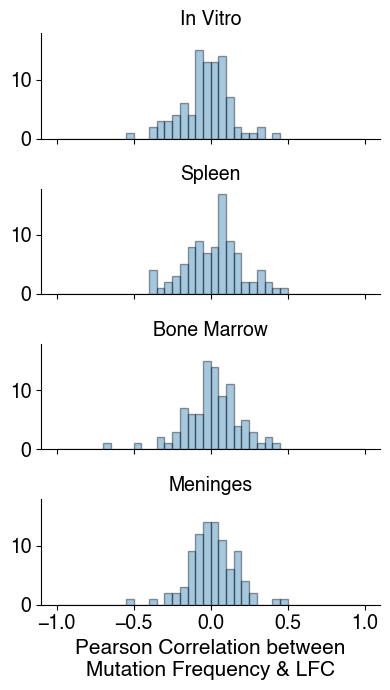

In [122]:
fig, ax= plt.subplots(4,1, figsize=(4,7), sharey=True, sharex=True)


corr_df3 = corr_df2[corr_df2['num_gRNAs']>=30]

ax[0].hist(corr_df3['corr_iv'], bins = np.linspace(-1,1,41), alpha=.4, edgecolor='black')
ax[1].hist(corr_df3['corr_spleen'], bins = np.linspace(-1,1,41), alpha=.4, edgecolor='black')
ax[2].hist(corr_df3['corr_bone'], bins = np.linspace(-1,1,41), alpha=.4, edgecolor='black')
ax[3].hist(corr_df3['corr_men'], bins = np.linspace(-1,1,41), alpha=.4, edgecolor='black')
ax[0].set_title('In Vitro', fontsize=14)
ax[1].set_title('Spleen', fontsize=14)
ax[2].set_title('Bone Marrow', fontsize=14)
ax[3].set_title('Meninges', fontsize=14)

for i in range(4):
    ax[i].spines[['top', 'right']].set_visible(False)
    ax[i].tick_params(axis='both', which='major', labelsize=14)
    ax[i].patch.set_facecolor('None')


ax[3].set_xlabel('Pearson Correlation between\nMutation Frequency & LFC', fontsize=15)
fig.tight_layout()
#fig.subplots_adjust(hspace=-.5)

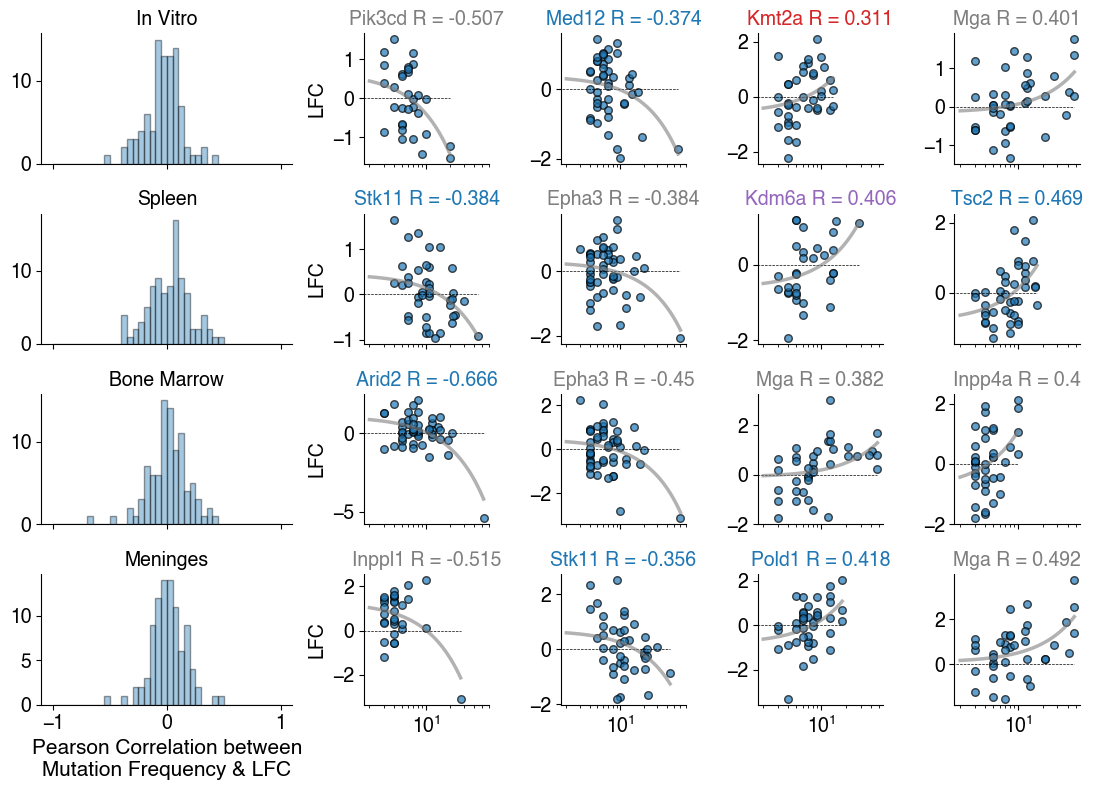

In [127]:
fig, ax= plt.subplots(4,5, figsize=(11,8), sharey=False, sharex='col', width_ratios=[1,.5, .5, .5, .5])


corr_df3 = corr_df2[corr_df2['num_gRNAs']>=30]

ax[0][0].hist(corr_df3['corr_iv'], bins = np.linspace(-1,1,41), alpha=.4, edgecolor='black')
ax[1][0].hist(corr_df3['corr_spleen'], bins = np.linspace(-1,1,41), alpha=.4, edgecolor='black')
ax[2][0].hist(corr_df3['corr_bone'], bins = np.linspace(-1,1,41), alpha=.4, edgecolor='black')
ax[3][0].hist(corr_df3['corr_men'], bins = np.linspace(-1,1,41), alpha=.4, edgecolor='black')
ax[0][0].set_title('In Vitro', fontsize=14)
ax[1][0].set_title('Spleen', fontsize=14)
ax[2][0].set_title('Bone Marrow', fontsize=14)
ax[3][0].set_title('Meninges', fontsize=14)


color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}

samps = ['corr_iv', 'corr_spleen', 'corr_bone', 'corr_men']

jj = ['LFC_In Vitro D15', 'LFC_Spleen', 'LFC_Bone', 'LFC_Meninges']
for idx, j in enumerate(samps):
    k = corr_df3.sort_values(by=j, ascending=False).reset_index()
    top = list(k['gene'])[0]
    top2 = list(k['gene'])[1]
    bot = list(k['gene'])[-1]
    bot2 = list(k['gene'])[-2]

    t1 = corr_df3.loc[corr_df3['gene']==top, 'Role in Cancer'].values[0]
    t2 = corr_df3.loc[corr_df3['gene']==top2, 'Role in Cancer'].values[0]
    b1 = corr_df3.loc[corr_df3['gene']==bot, 'Role in Cancer'].values[0]
    b2 = corr_df3.loc[corr_df3['gene']==bot2, 'Role in Cancer'].values[0]

    t_color = color_dict[t1]
    t_color2 = color_dict[t2]
    b_color = color_dict[b1]
    b_color2 = color_dict[b2]

    tissue = jj[idx]

    m2 = m1[(m1['gene_name_m']==top) & (m1['target_base_edit_perc']>=edit_cutoff)]
    x,y = m2['mutation_count'], m2[tissue]
    rr = np.round(scipy.stats.pearsonr(x,y).statistic,3)
    ax[idx][4].scatter(x,y, alpha=.7, edgecolor='black', s=30)
    ax[idx][4].set_xscale('log')
    ax[idx][4].set_title(f'{top} R = {rr}', fontsize=14,c=t_color)
    ax[idx][4].plot([0,max(x)], [0,0], linewidth=.5, color='black', linestyle='dashed')


    b, a = np.polyfit(x, y, deg=1)
    xseq = np.linspace(2, max(x), num=100)
    # Plot regression line
    ax[idx][4].plot(xseq, a + b * xseq, color="tab:grey", lw=2.5, alpha=.6)



    m2 = m1[(m1['gene_name_m']==top2) & (m1['target_base_edit_perc']>=edit_cutoff)]
    x,y = m2['mutation_count'], m2[tissue]
    rr = np.round(scipy.stats.pearsonr(x,y).statistic,3)
    ax[idx][3].scatter(x,y, alpha=.7, edgecolor='black', s=30)
    ax[idx][3].set_xscale('log')
    ax[idx][3].set_title(f'{top2} R = {rr}', fontsize=14,c=t_color2)
    ax[idx][3].plot([0,max(x)], [0,0], linewidth=.5, color='black', linestyle='dashed')
    
    b, a = np.polyfit(x, y, deg=1)
    xseq = np.linspace(2, max(x), num=100)
    # Plot regression line
    ax[idx][3].plot(xseq, a + b * xseq, color="tab:grey", lw=2.5, alpha=.6)

    m2 = m1[(m1['gene_name_m']==bot2) & (m1['target_base_edit_perc']>=edit_cutoff)]
    x,y = m2['mutation_count'], m2[tissue]
    rr = np.round(scipy.stats.pearsonr(x,y).statistic,3)
    ax[idx][2].scatter(x,y, alpha=.7, edgecolor='black', s=30)
    ax[idx][2].set_xscale('log')
    ax[idx][2].set_title(f'{bot2} R = {rr}', fontsize=14, c=b_color2)
    ax[idx][2].plot([0,max(x)], [0,0], linewidth=.5, color='black', linestyle='dashed')


    b, a = np.polyfit(x, y, deg=1)
    xseq = np.linspace(2, max(x), num=100)
    # Plot regression line
    ax[idx][2].plot(xseq, a + b * xseq, color="tab:grey", lw=2.5, alpha=.6)


    m2 = m1[(m1['gene_name_m']==bot) & (m1['target_base_edit_perc']>=edit_cutoff)]
    x,y = m2['mutation_count'], m2[tissue]
    rr = np.round(scipy.stats.pearsonr(x,y).statistic,3)
    ax[idx][1].scatter(x,y, alpha=.7, edgecolor='black', s=30)
    ax[idx][1].set_xscale('log')
    ax[idx][1].set_title(f'{bot} R = {rr}', fontsize=14, c=b_color)
    ax[idx][1].plot([0,max(x)], [0,0], linewidth=.5, color='black', linestyle='dashed')


    b, a = np.polyfit(x, y, deg=1)
    xseq = np.linspace(2, max(x), num=100)
    # Plot regression line
    ax[idx][1].plot(xseq, a + b * xseq, color="tab:grey", lw=2.5, alpha=.6)


    ax[idx][1].set_ylabel('LFC', fontsize=14)
    #ax[idx][2].set_ylabel('LFC', fontsize=14)
    #ax[idx][3].set_ylabel('LFC', fontsize=14)
    #ax[idx][4].set_ylabel('LFC', fontsize=14)

    

for i in range(4):
    for k in range(5):
        ax[i][k].spines[['top', 'right']].set_visible(False)
        ax[i][k].tick_params(axis='both', which='major', labelsize=14)
        ax[i][k].patch.set_facecolor('None')


ax[3][0].set_xlabel('Pearson Correlation between\nMutation Frequency & LFC', fontsize=15)
fig.tight_layout()
#fig.savefig('figures/fig4_freqv2.pdf')

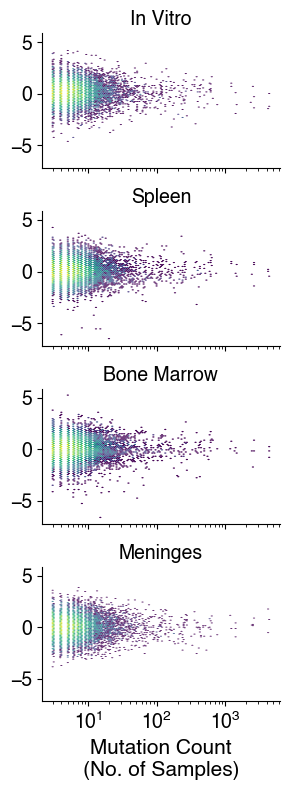

In [124]:
edit_cutoff = 20
m2 = m1[(m1['target_base_edit_perc']>=edit_cutoff)]

fig, ax= plt.subplots(4,1, figsize=(3,8), sharey=True, sharex=True)

corr_df3 = corr_df2[corr_df2['num_gRNAs']>=30]

#ax[0].set_xscale('log')

ax[0].hexbin(m2['mutation_count'], m2['Z_In Vitro D15'], bins='log', xscale='log', linewidths=0)
ax[1].hexbin(m2['mutation_count'], m2['Z_Spleen'], bins='log', xscale='log', linewidths=0)
ax[2].hexbin(m2['mutation_count'], m2['Z_Bone'], bins='log', xscale='log', linewidths=0)
ax[3].hexbin(m2['mutation_count'], m2['Z_Meninges'], bins='log', xscale='log', linewidths=0)


ax[0].set_title('In Vitro', fontsize=14)
ax[1].set_title('Spleen', fontsize=14)
ax[2].set_title('Bone Marrow', fontsize=14)
ax[3].set_title('Meninges', fontsize=14)

for i in range(4):
    ax[i].spines[['top', 'right']].set_visible(False)
    ax[i].tick_params(axis='both', which='major', labelsize=14)
    ax[i].patch.set_facecolor('None')


ax[3].set_xlabel('Mutation Count\n(No. of Samples)', fontsize=15)
fig.tight_layout()
#fig.savefig('figures/fig4_a.pdf')

# KO vs. BE

In [109]:
KO = pd.read_csv('KO_LFC.csv')
KO

KO_spleen = KO[['sgrna', 'LFC_spleen']].rename(columns = {'sgrna':'gRNA_id', 'LFC_spleen':'LFC_KO'})


BE = pd.read_csv('master_table_min50_control_mean_invitro.csv')
BE = BE[(BE['classification']=='targeting guide') & (BE['Editor']=='ABE') & (BE['target_base_edit_perc']>=20)]

merged = pd.merge(KO_spleen, BE, on='gRNA_id')


cosmic = pd.read_csv('source_data/Census_allSun Nov 17 02_26_47 2024.csv').fillna('Undefined')

#MBES = pd.read_csv('MBESv2_CORRECTED.csv')

t_dict = {'TSG':'TSG', 'TSG, fusion':'TSG', 'Undefined':'Undefined', 'fusion':'Undefined', 'oncogene':'Oncogene',
       'oncogene, TSG':'Oncogene/TSG', 'oncogene, TSG, fusion':'Oncogene/TSG', 'oncogene, fusion': 'Oncogene'}

gene_type = []
for i, val in merged.iterrows():
    v = val['gene_name_h']
    subset = cosmic[cosmic['Gene Symbol']==v]
    if len(subset)==0:
        gene_type.append('Undefined')
    else:
        v2 = subset['Role in Cancer'].values[0]

        gene_type.append(t_dict[v2])

merged['Role in Cancer']=gene_type

In [110]:
x = merged['LFC_KO']
y = merged['LFC_Spleen']

delta = y-x

merged['delta'] = delta
merged.sort_values(by='delta', ascending=False)[:10]

,gRNA_id,LFC_KO,mutation_idx,gene_name_h,gene_id_h,tx_id_h,chr_h,exon_num_h,strand_h,match,...,Z_Bone,Z_Spleen,Z_Meninges,sensor_reads,corr_perc,target_base_edit_perc,byproduct_INDEL_perc,byproduct_sub_perc,Role in Cancer,delta
116,gRNA_901,-6.2253,740,ARID5B,ENSG00000150347.10,ENST00000279873.7,chr10,10.0,+,True,...,1.108759,0.456311,1.394859,440,84.090909,92.954545,1.818182,8.863636,Undefined,6.73076
240,gRNA_4621,-4.3365,3895,FOXO1,ENSG00000150907.6,ENST00000379561.5,chr13,2.0,-,True,...,2.607760,1.940963,1.453825,420,68.809524,74.285714,0.238095,14.761905,Oncogene/TSG,6.24680
97,gRNA_6781,-5.1948,5606,LCK,ENSG00000182866.12,ENST00000336890.5,chr1,12.0,+,True,...,1.484407,0.224816,0.909954,1473,80.312288,96.198235,2.104549,15.885947,Oncogene,5.48121
264,gRNA_12164,-2.2050,10049,SYK,ENSG00000165025.10,ENST00000375746.1,chr9,13.0,+,True,...,5.255373,3.367025,1.956047,1351,0.074019,69.504071,0.000000,98.001480,Oncogene,5.46470
214,gRNA_12579,-3.6585,10410,TP53,ENSG00000141510.11,ENST00000269305.4,chr17,10.0,-,True,...,0.677830,1.778636,1.383066,477,51.991614,97.484277,0.628931,26.624738,Oncogene/TSG,5.41520
123,gRNA_12548,-3.4306,10380,TP53,ENSG00000141510.11,ENST00000269305.4,chr17,10.0,-,True,...,0.829605,1.974675,0.008113,949,69.441517,95.574289,0.000000,27.713383,Oncogene/TSG,5.37280
228,gRNA_10504,-3.2887,8713,RBM10,ENSG00000182872.11,ENST00000377604.3,chrX,23.0,+,True,...,1.990511,1.817738,1.489736,968,45.557851,97.623967,0.516529,51.652893,TSG,5.08240
178,gRNA_1848,-5.2934,1504,CARM1,ENSG00000142453.7,ENST00000327064.4,chr19,16.0,+,True,...,0.230711,-0.474994,-0.568935,517,87.814313,90.522244,0.000000,3.094778,Undefined,4.91762
317,gRNA_3905,-2.5884,3332,ETV6,ENSG00000139083.6,ENST00000396373.4,chr12,8.0,+,True,...,2.390633,2.013566,1.144635,1359,94.775570,97.130243,0.000000,2.869757,TSG,4.56740
106,gRNA_95,-3.8562,75,AKT1,ENSG00000142208.11,ENST00000349310.3,chr14,13.0,-,True,...,0.396486,0.657834,-2.193055,386,73.316062,96.632124,0.000000,25.647668,Oncogene,4.55235


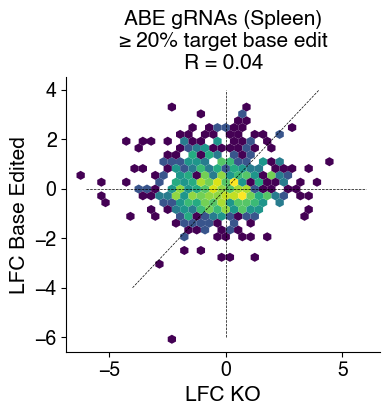

In [128]:
#plt.scatter(x,y)

x = merged['LFC_KO']
y = merged['LFC_Spleen']

fig, ax = plt.subplots(figsize=(4,4.25))
ax.hexbin(x,y, bins='log', gridsize=30, linewidths=0)
ax.plot([-6,6],[0,0], linestyle='dashed', color='black', linewidth=.5)
ax.plot([0,0],[-6,4], linestyle='dashed', color='black', linewidth=.5)
ax.plot([-4,4],[-4,4], linestyle='dashed', color='black', linewidth=.5)

ax.set_xlabel('LFC KO', fontsize=15)
ax.set_ylabel('LFC Base Edited', fontsize=15)

ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_title(f'ABE gRNAs (Spleen)\n≥ 20% target base edit\nR = {np.round(scipy.stats.pearsonr(x,y).statistic, 2)}', fontsize=15)
fig.tight_layout()
#fig.savefig('figures/fig4c_v2.pdf')

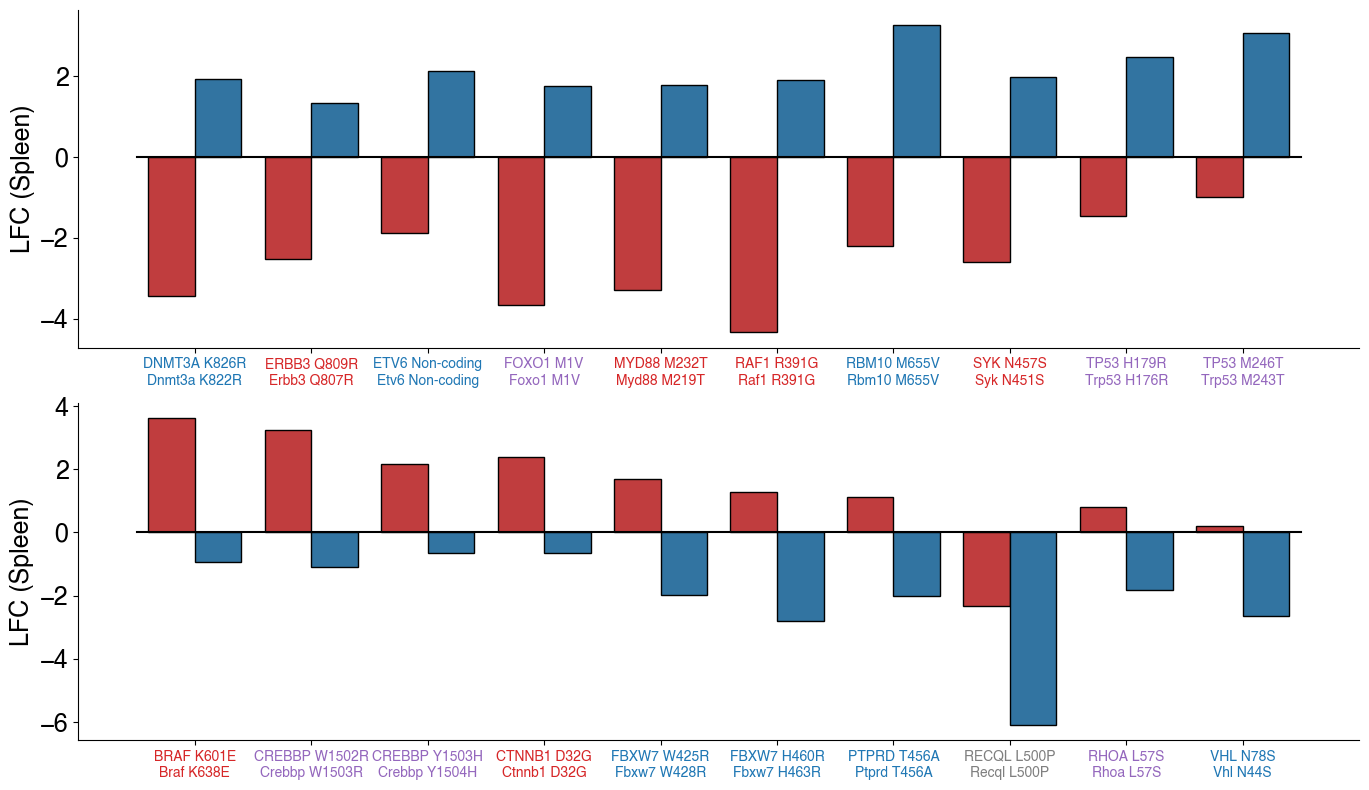

In [5]:
KO2 = KO.rename(columns = {'sgrna':'gRNA_id', 'LFC_spleen':'LFC_Spleen'})
KO2['Type'] = 'KO'
BE['Type'] = 'BE'
concated = pd.concat((KO2, BE))


cc2_top = merged.sort_values(by=f'delta', ascending=False)
cc2_top = cc2_top[cc2_top['LFC_Spleen']>=1]


top = list(cc2_top[:10]['gRNA_id'])

cc2_bot = merged.sort_values(by=f'delta', ascending=True)
cc2_bot = cc2_bot[cc2_bot['LFC_Spleen']<=-.5]

bot =  list(cc2_bot[:10]['gRNA_id'])

fig, ax = plt.subplots(2,1,figsize=(14,8))
subset = concated[concated['gRNA_id'].isin(top)]
h = sns.barplot(data = subset, x='gRNA_id', y='LFC_Spleen', hue='Type', edgecolor='black', ax=ax[0], palette=['tab:red', 'tab:blue'], legend=False)
ax[0].plot([-.5,9.5],[0,0], c='black')

name = []
hum_gene = []
for i, val in subset[subset['Type']=='BE'].iterrows():
    a = val['gene_name_h']
    b = val['HGVSp_h']
    c = val['gene_name_m']
    d = val['HGVSp_m']
    hum_gene.append(a)

    if type(b) != str:
        b = 'Non-coding'

    n = f'{a} {b}\n{c} {d}'
    name.append(n)

ax[0].set_xticklabels(name)


color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}
#t2 = list(t1['Role in Cancer'])
for idx, tick_label in enumerate(h.axes.get_xticklabels()):
    aa = merged.loc[merged['gene_name_h']==hum_gene[idx], 'Role in Cancer'].values[0]
    tick_label.set_color(color_dict[aa])

subset = concated[concated['gRNA_id'].isin(bot)]
g = sns.barplot(data = subset, x='gRNA_id', y='LFC_Spleen', hue='Type', edgecolor='black', ax=ax[1], palette=['tab:red', 'tab:blue'], legend=False)
ax[1].plot([-.5,9.5],[0,0], c='black')
ax[1].set_ylabel('LFC (Spleen)', fontsize=18)
ax[0].set_ylabel('LFC (Spleen)', fontsize=18)
ax[0].set_xlabel('')
ax[1].set_xlabel('')


name = []
hum_gene = []
for i, val in subset[subset['Type']=='BE'].iterrows():
    a = val['gene_name_h']
    b = val['HGVSp_h']
    c = val['gene_name_m']
    d = val['HGVSp_m']

    hum_gene.append(a)

    n = f'{a} {b}\n{c} {d}'
    name.append(n)

ax[1].set_xticklabels(name)

ax[0].spines[['top', 'right']].set_visible(False)
ax[0].tick_params(axis='x', which='major', labelsize=10)
ax[0].tick_params(axis='y', which='major', labelsize=18)

ax[1].spines[['top', 'right']].set_visible(False)
ax[1].tick_params(axis='x', which='major', labelsize=10)
ax[1].tick_params(axis='y', which='major', labelsize=18)

color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}
#t2 = list(t1['Role in Cancer'])
for idx, tick_label in enumerate(g.axes.get_xticklabels()):
    aa = merged.loc[merged['gene_name_h']==hum_gene[idx], 'Role in Cancer'].values[0]
    tick_label.set_color(color_dict[aa])

fig.tight_layout()
#fig.savefig('figures/fig4d.pdf')

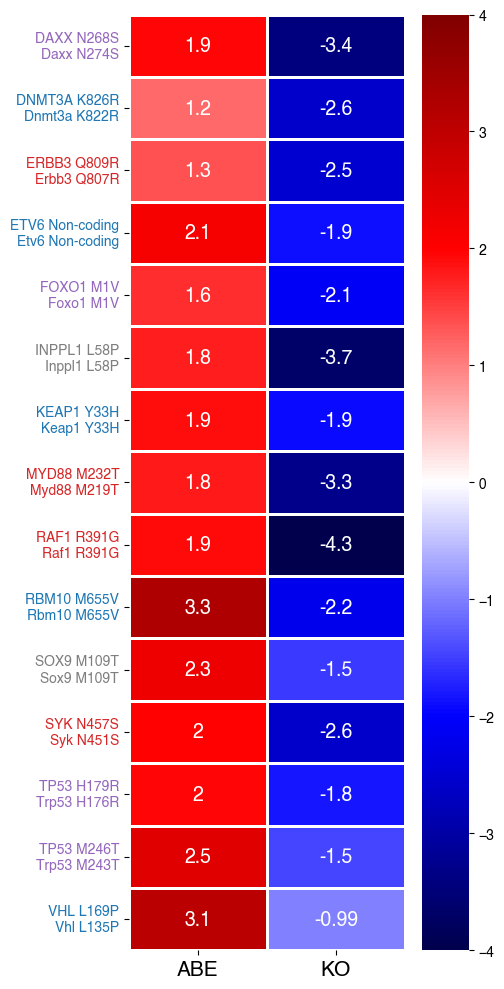

In [115]:
cc2_top = merged.sort_values(by=f'delta', ascending=False)
cc2_top = cc2_top[cc2_top['LFC_Spleen']>=1].sort_values(by=f'delta', ascending=False)


top = list(cc2_top[:15]['gRNA_id'])

cc2_bot = merged.sort_values(by=f'delta', ascending=True)
cc2_bot = cc2_bot[cc2_bot['LFC_Spleen']<=-.5].sort_values(by=f'delta', ascending=True)

bot =  list(cc2_bot[:15]['gRNA_id'])

#fig, ax = plt.subplots(2,1,figsize=(14,8))
subset = concated[concated['gRNA_id'].isin(top)]


top_T = merged[merged['gRNA_id'].isin(top)][['LFC_Spleen', 'LFC_KO']] #['LFC_KO', 'LFC_spleen']


fig, ax = plt.subplots(figsize=(5,10))
g = sns.heatmap(top_T, cmap='seismic', linewidths=1, vmin=-4, vmax=4, annot=True, annot_kws={'size':14})

name = []
hum_gene = []
for i, val in subset[subset['Type']=='BE'].iterrows():
    a = val['gene_name_h']
    b = val['HGVSp_h']
    c = val['gene_name_m']
    d = val['HGVSp_m']
    hum_gene.append(a)

    if type(b) != str:
        b = 'Non-coding'

    n = f'{a} {b}\n{c} {d}'
    name.append(n)

ax.set_yticklabels(name, rotation=0)
ax.set_xticklabels(['ABE', 'KO'], fontsize=15)

color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}
#t2 = list(t1['Role in Cancer'])
for idx, tick_label in enumerate(g.axes.get_yticklabels()):
    aa = merged.loc[merged['gene_name_h']==hum_gene[idx], 'Role in Cancer'].values[0]
    tick_label.set_color(color_dict[aa])

fig.tight_layout()

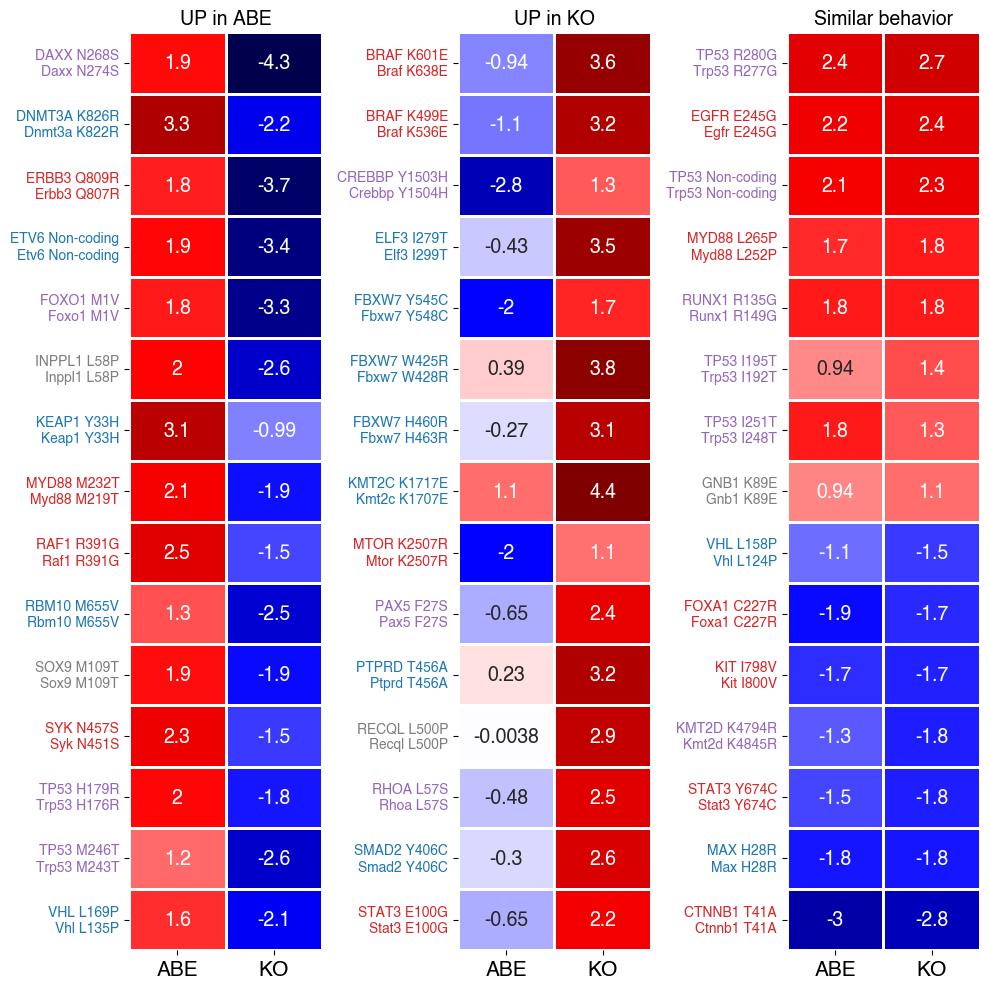

In [129]:
cc2_top = merged.sort_values(by=f'delta', ascending=False)
cc2_top = cc2_top[cc2_top['LFC_Spleen']>=1]


top = list(cc2_top[:15]['gRNA_id'])

cc2_bot = merged.sort_values(by=f'delta', ascending=True)
cc2_bot = cc2_bot[cc2_bot['LFC_KO']>=1]

bot =  list(cc2_bot[:15]['gRNA_id'])

#fig, ax = plt.subplots(2,1,figsize=(14,8))
subset = concated[concated['gRNA_id'].isin(top)]


top_T = merged[merged['gRNA_id'].isin(top)].sort_values(by=f'delta', ascending=False)[['LFC_Spleen', 'LFC_KO']] #['LFC_KO', 'LFC_spleen']


fig, ax = plt.subplots(1,3, figsize=(10,10))
#----number 1
g = sns.heatmap(top_T, cmap='seismic', linewidths=1, vmin=-4, vmax=4, annot=True, annot_kws={'size':14}, ax=ax[0], cbar=False)

name = []
hum_gene = []
for i, val in subset[subset['Type']=='BE'].iterrows():
    a = val['gene_name_h']
    b = val['HGVSp_h']
    c = val['gene_name_m']
    d = val['HGVSp_m']
    hum_gene.append(a)

    if type(b) != str:
        b = 'Non-coding'

    n = f'{a} {b}\n{c} {d}'
    name.append(n)

ax[0].set_yticklabels(name, rotation=0)
ax[0].set_xticklabels(['ABE', 'KO'], fontsize=15)

color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}
#t2 = list(t1['Role in Cancer'])
for idx, tick_label in enumerate(g.axes.get_yticklabels()):
    aa = merged.loc[merged['gene_name_h']==hum_gene[idx], 'Role in Cancer'].values[0]
    tick_label.set_color(color_dict[aa])


top_T = merged[merged['gRNA_id'].isin(top)][['LFC_Spleen', 'LFC_KO']] #['LFC_KO', 'LFC_spleen']


#-------number 2

top_T = merged[merged['gRNA_id'].isin(bot)].sort_values(by=f'delta', ascending=True)[['LFC_Spleen', 'LFC_KO']] #['LFC_KO', 'LFC_spleen']

h = sns.heatmap(top_T, cmap='seismic', linewidths=1, vmin=-4, vmax=4, annot=True, annot_kws={'size':14}, ax=ax[1], cbar=False)

subset = concated[concated['gRNA_id'].isin(bot)]


name = []
hum_gene = []
for i, val in subset[subset['Type']=='BE'].iterrows():
    a = val['gene_name_h']
    b = val['HGVSp_h']
    c = val['gene_name_m']
    d = val['HGVSp_m']
    hum_gene.append(a)

    if type(b) != str:
        b = 'Non-coding'

    n = f'{a} {b}\n{c} {d}'
    name.append(n)

ax[1].set_yticklabels(name, rotation=0)
ax[1].set_xticklabels(['ABE', 'KO'], fontsize=15)

color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}
#t2 = list(t1['Role in Cancer'])
for idx, tick_label in enumerate(h.axes.get_yticklabels()):
    aa = merged.loc[merged['gene_name_h']==hum_gene[idx], 'Role in Cancer'].values[0]
    tick_label.set_color(color_dict[aa])



#------number 3
t1 = merged[(merged['delta']>-.5) & (merged['delta']<.5)].sort_values(by='LFC_KO', ascending=False)[:8]
t2 = merged[(merged['delta']>-.5) & (merged['delta']<.5)].sort_values(by='LFC_KO', ascending=False)[-7:]
similars = pd.concat((t1, t2))

similars2 = similars[['LFC_Spleen', 'LFC_KO']]

f = sns.heatmap(similars2, cmap='seismic', linewidths=1, vmin=-4, vmax=4, annot=True, annot_kws={'size':14}, ax=ax[2], cbar=False)

name = []
hum_gene = []
for i, val in similars.iterrows():
    a = val['gene_name_h']
    b = val['HGVSp_h']
    c = val['gene_name_m']
    d = val['HGVSp_m']
    hum_gene.append(a)

    if type(b) != str:
        b = 'Non-coding'

    n = f'{a} {b}\n{c} {d}'
    name.append(n)

ax[2].set_yticklabels(name, rotation=0)
ax[2].set_xticklabels(['ABE', 'KO'], fontsize=15)

color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}
#t2 = list(t1['Role in Cancer'])
for idx, tick_label in enumerate(f.axes.get_yticklabels()):
    aa = merged.loc[merged['gene_name_h']==hum_gene[idx], 'Role in Cancer'].values[0]
    tick_label.set_color(color_dict[aa])

ax[0].set_title('UP in ABE', fontsize=14)
ax[1].set_title('UP in KO', fontsize=14)
ax[2].set_title('Similar behavior', fontsize=14)


fig.tight_layout()
#fig.savefig('figures/figure4_heatmap_cbarv2.pdf')

In [99]:


t1 = merged[(merged['delta']>-.5) & (merged['delta']<.5)].sort_values(by='LFC_KO', ascending=False)[:8]
t2 = merged[(merged['delta']>-.5) & (merged['delta']<.5)].sort_values(by='LFC_KO', ascending=False)[-7:]
similars = pd.concat((t1, t2))

,gRNA_id,LFC_KO,mutation_idx,gene_name_h,gene_id_h,tx_id_h,chr_h,exon_num_h,strand_h,match,...,Z_Bone,Z_Spleen,Z_Meninges,sensor_reads,corr_perc,target_base_edit_perc,byproduct_INDEL_perc,byproduct_sub_perc,Role in Cancer,delta
16,gRNA_12604,2.7424,10448,TP53,ENSG00000141510.11,ENST00000269305.4,chr17,10.0,-,True,...,1.931009,2.510267,1.662020,1326,47.963801,90.497738,0.301659,44.871795,Oncogene/TSG,-0.29340
28,gRNA_3012,2.4486,2535,EGFR,ENSG00000146648.11,ENST00000275493.2,chr7,28.0,+,True,...,1.636979,2.270371,1.666099,2799,0.607360,53.483387,0.821722,88.495891,Oncogene,-0.22660
18,gRNA_12567,2.3393,10404,TP53,ENSG00000141510.11,ENST00000269305.4,chr17,10.0,-,True,...,0.768048,2.178428,1.532652,1477,31.821259,50.169262,0.473934,25.930941,Oncogene/TSG,-0.20430
50,gRNA_7510,1.7995,6251,MYD88,ENSG00000172936.8,ENST00000396334.3,chr3,5.0,+,True,...,1.718486,1.681515,-0.192711,2696,30.081602,93.954006,0.037092,64.910979,Oncogene,-0.13470
45,gRNA_10969,1.7979,9105,RUNX1,ENSG00000159216.14,ENST00000344691.4,chr21,6.0,-,True,...,1.352717,1.834647,0.976695,2470,90.647773,95.384615,0.161943,5.870445,Oncogene/TSG,0.01180
86,gRNA_12523,1.4007,10353,TP53,ENSG00000141510.11,ENST00000269305.4,chr17,10.0,-,True,...,1.603186,0.911395,0.410648,2345,20.938166,85.415778,0.085288,67.633262,Oncogene/TSG,-0.46462
98,gRNA_12601,1.2955,10438,TP53,ENSG00000141510.11,ENST00000269305.4,chr17,10.0,-,True,...,0.936719,1.818690,1.191807,1174,0.425894,89.948893,0.000000,91.056218,Oncogene/TSG,0.49910
104,gRNA_4893,1.1440,4086,GNB1,ENSG00000078369.13,ENST00000378609.4,chr1,9.0,-,True,...,-0.265187,0.913583,0.246184,2117,27.113840,59.187530,0.708550,38.497874,Undefined,-0.20585
320,gRNA_13003,-1.5403,10752,VHL,ENSG00000134086.7,ENST00000256474.2,chr3,3.0,+,True,...,-1.147635,-1.282631,0.054987,2428,25.247117,34.802306,0.041186,19.563427,TSG,0.40030
227,gRNA_4547,-1.6622,3840,FOXA1,ENSG00000129514.4,ENST00000250448.2,chr14,2.0,-,True,...,-1.607451,-2.117935,-1.183821,2132,23.639775,26.313321,0.046904,7.692308,Oncogene,-0.26820


In [90]:
merged

,gRNA_id,LFC_KO,mutation_idx,gene_name_h,gene_id_h,tx_id_h,chr_h,exon_num_h,strand_h,match,...,Z_Bone,Z_Spleen,Z_Meninges,sensor_reads,corr_perc,target_base_edit_perc,byproduct_INDEL_perc,byproduct_sub_perc,Role in Cancer,delta
0,gRNA_8513,4.442100,7035,PAX5,ENSG00000196092.8,ENST00000358127.4,chr9,10.0,-,True,...,0.526739,1.111788,1.658030,1701,3.703704,33.921223,0.000000,86.831276,Oncogene/TSG,-3.316400
1,gRNA_1569,3.802100,1291,BRAF,ENSG00000157764.8,ENST00000288602.6,chr7,18.0,-,True,...,0.550080,0.336743,0.352312,3736,55.942184,84.502141,0.000000,28.667024,Oncogene,-3.409780
2,gRNA_6383,3.546000,5276,KMT2C,ENSG00000055609.13,ENST00000262189.6,chr7,59.0,-,True,...,-0.802602,-0.533858,0.110474,2264,1.899293,31.272085,0.088339,63.825088,TSG,-3.977480
3,gRNA_1552,3.626800,1271,BRAF,ENSG00000157764.8,ENST00000288602.6,chr7,18.0,-,True,...,-0.666601,-1.070053,-1.196324,2575,51.728155,78.757282,3.883495,34.640777,Oncogene,-4.565650
4,gRNA_11099,3.503100,9214,SETD2,ENSG00000181555.15,ENST00000409792.3,chr3,21.0,-,True,...,0.219563,0.678368,-0.747435,1410,38.439716,96.170213,0.283688,56.879433,TSG,-2.787520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,gRNA_2950,0.010931,2487,EED,ENSG00000074266.13,ENST00000263360.6,chr11,12.0,+,True,...,0.128637,-0.435237,-0.724417,1148,36.846690,46.167247,0.087108,20.296167,TSG,-0.349091
732,gRNA_5792,-0.006988,4811,JAK3,ENSG00000105639.14,ENST00000458235.1,chr19,23.0,-,True,...,-0.719670,0.072149,-0.085723,1949,10.877373,27.552591,4.002052,56.900975,Oncogene,0.148938
733,gRNA_5176,0.006423,4337,HRAS,ENSG00000174775.12,ENST00000311189.7,chr11,4.0,-,True,...,-0.683104,-1.110814,0.908721,1909,10.110005,37.297014,0.157150,58.512310,Oncogene,-0.983843
734,gRNA_10679,0.004421,8871,RIT1,ENSG00000143622.6,ENST00000368323.3,chr1,5.0,-,True,...,1.195766,-0.357815,-0.480913,1805,3.545706,90.304709,0.000000,86.814404,Undefined,-0.269321


In [45]:
merged.columns

Index(['gRNA_id', 'LFC_KO', 'mutation_idx', 'gene_name_h', 'gene_id_h',
       'tx_id_h', 'chr_h', 'exon_num_h', 'strand_h', 'match', 'start_h',
       'end_h', 'ref_seq_h', 'alt_seq_h', 'HGVSc_h', 'HGVSp_h',
       'classification_h', 'exon_h', 'type_h', 'status', 'error', 'statement',
       'gene_name_m', 'gene_id_m', 'tx_id_m', 'chr_m', 'exon_num_m',
       'strand_m', 'type_m', 'classification_m', 'exon_m', 'start_m', 'end_m',
       'ref_seq_m', 'alt_seq_m', 'HGVSc_m', 'HGVSp_m', 'PAM', 'PAM_strand',
       'Protospacer_30', 'Protospacer', 'Protospacer_Location',
       'Ideal_Edit_Window', 'Editor', 'OnTarget_Azimuth_Score', 'sensor_wt',
       'sensor_alt', 'sensor_orientation', 'sensor_error',
       'contains_polyT_terminator', 'contains_RE_site', 'num_potential_vars',
       'classification', 'Genome_version', 'Hamming_BC', 'Pool', 'gRNA_oligo',
       'gene_name_m_corrected', 'legacy', 'LFC_In Vitro D15',
       'treat_mean_In Vitro D15', 'control_mean_In Vitro D15',
      

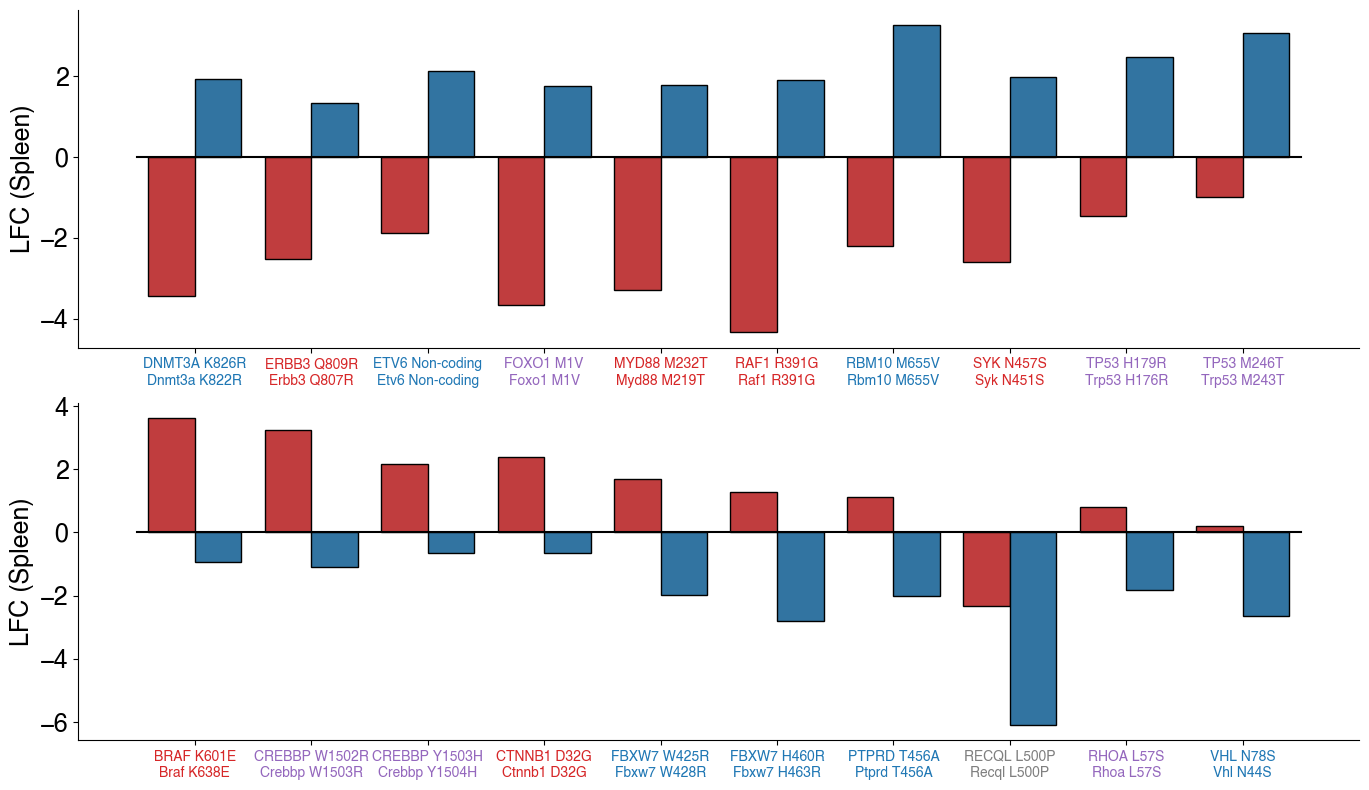

In [35]:
KO2 = KO.rename(columns = {'sgrna':'gRNA_id', 'LFC_spleen':'LFC_Spleen'})
KO2['Type'] = 'KO'
BE['Type'] = 'BE'
concated = pd.concat((KO2, BE))


cc2_top = merged.sort_values(by=f'delta', ascending=False)
cc2_top = cc2_top[cc2_top['LFC_Spleen']>=1]


top = list(cc2_top[:10]['gRNA_id'])

cc2_bot = merged.sort_values(by=f'delta', ascending=True)
cc2_bot = cc2_bot[cc2_bot['LFC_Spleen']<=-.5]

bot =  list(cc2_bot[:10]['gRNA_id'])

fig, ax = plt.subplots(2,1,figsize=(14,8))
subset = concated[concated['gRNA_id'].isin(top)]


h = sns.barplot(data = subset, x='gRNA_id', y='LFC_Spleen', hue='Type', edgecolor='black', ax=ax[0], palette=['tab:red', 'tab:blue'], legend=False)
ax[0].plot([-.5,9.5],[0,0], c='black')

name = []
hum_gene = []
for i, val in subset[subset['Type']=='BE'].iterrows():
    a = val['gene_name_h']
    b = val['HGVSp_h']
    c = val['gene_name_m']
    d = val['HGVSp_m']
    hum_gene.append(a)

    if type(b) != str:
        b = 'Non-coding'

    n = f'{a} {b}\n{c} {d}'
    name.append(n)

ax[0].set_xticklabels(name)


color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}
#t2 = list(t1['Role in Cancer'])
for idx, tick_label in enumerate(h.axes.get_xticklabels()):
    aa = merged.loc[merged['gene_name_h']==hum_gene[idx], 'Role in Cancer'].values[0]
    tick_label.set_color(color_dict[aa])

subset = concated[concated['gRNA_id'].isin(bot)]
g = sns.barplot(data = subset, x='gRNA_id', y='LFC_Spleen', hue='Type', edgecolor='black', ax=ax[1], palette=['tab:red', 'tab:blue'], legend=False)
ax[1].plot([-.5,9.5],[0,0], c='black')
ax[1].set_ylabel('LFC (Spleen)', fontsize=18)
ax[0].set_ylabel('LFC (Spleen)', fontsize=18)
ax[0].set_xlabel('')
ax[1].set_xlabel('')


name = []
hum_gene = []
for i, val in subset[subset['Type']=='BE'].iterrows():
    a = val['gene_name_h']
    b = val['HGVSp_h']
    c = val['gene_name_m']
    d = val['HGVSp_m']

    hum_gene.append(a)

    n = f'{a} {b}\n{c} {d}'
    name.append(n)

ax[1].set_xticklabels(name)

ax[0].spines[['top', 'right']].set_visible(False)
ax[0].tick_params(axis='x', which='major', labelsize=10)
ax[0].tick_params(axis='y', which='major', labelsize=18)

ax[1].spines[['top', 'right']].set_visible(False)
ax[1].tick_params(axis='x', which='major', labelsize=10)
ax[1].tick_params(axis='y', which='major', labelsize=18)

color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}
#t2 = list(t1['Role in Cancer'])
for idx, tick_label in enumerate(g.axes.get_xticklabels()):
    aa = merged.loc[merged['gene_name_h']==hum_gene[idx], 'Role in Cancer'].values[0]
    tick_label.set_color(color_dict[aa])

fig.tight_layout()

In [6]:
TFs = pd.read_excel('source_data/gene_classifications/Human_TF_Gold_Standard_CRISPR_Nuclease.xlsx')[['Gene']]
ubiquitin_ligases = pd.read_excel('source_data/gene_classifications/Hs-Ubiquitin-Ligases-Pooled-shRNA-Library-Gene-List.xlsx').rename(columns = {'Gene Symbol':'Gene'})
kinome = pd.read_excel('source_data/gene_classifications/Vakoc_Human_Kinome_Gene_List.xlsx').rename(columns = {'Symbol':'Gene'}).drop_duplicates().reset_index(drop=True)
DDR = pd.read_excel('source_data/gene_classifications/Human_DDR_Gold_Standard_CRISPR_Nuclease.xlsx')[['Gene']]
chromatin = pd.read_excel('source_data/gene_classifications/Human_Chromatin_Gold_Standard_CRISPR_Nuclease.xlsx')[['Gene']].drop_duplicates().reset_index(drop=True)
rbps = pd.read_excel('source_data/gene_classifications/RBPs.xlsx', header=1).rename(columns = {'Gene name':'Gene'}).drop_duplicates().reset_index(drop=True)
druggable = pd.read_excel('source_data/gene_classifications/SaturnV_v2.0_Human_CRISPR_Input_DRUGGABLE.xlsx')[['Gene']].drop_duplicates().reset_index(drop=True)
chip = pd.read_excel('source_data/gene_classifications/CHIP_CH_Mutational_Compendium41586_2020_2819_MOESM1_ESM.xlsx', sheet_name='S3', header=1)[['Gene']].drop_duplicates(subset='Gene').reset_index(drop=True)


TFs['gene_function'] = 'TF'
ubiquitin_ligases['gene_function'] = 'Ubiquitin Ligase'
kinome['gene_function'] = 'Kinase'
DDR['gene_function'] = 'DDR'
chromatin['gene_function'] = 'Chromatin'
rbps['gene_function'] = 'RBP'
druggable['gene_function'] = 'Druggable Genome'
chip['gene_function'] = 'CHIP'

gene_funcs = pd.concat((TFs, ubiquitin_ligases, kinome, DDR, chromatin, rbps, druggable, chip))[['Gene', 'gene_function']]

In [7]:
MBES = pd.read_csv('MBESv2_CORRECTED.csv')
MBES_targ =  MBES[MBES['classification']=='targeting guide'].drop_duplicates(subset='gene_name_h').reset_index(drop=True)[['gene_name_h']]


tfs = []
ubiq = []
kin = []
ddr_list = []
chrom = []
rbp_list = []
drug = []
chip_list = []

multiple = []
classified = []

for i, val in MBES_targ.iterrows():

    g = val['gene_name_h']

    subset = list(gene_funcs[gene_funcs['Gene']==g]['gene_function'])

    if len(subset)==0:
        tfs.append(False)
        ubiq.append(False)
        kin.append(False)
        ddr_list.append(False)
        chrom.append(False)
        rbp_list.append(False)
        drug.append(False)
        chip_list.append(False)

        multiple.append(False)
        classified.append(False)
    
    elif len(subset)>=1:
        classified.append(True)
        if len(subset)>=2:
            multiple.append(True)
        elif len(subset)==1:
            multiple.append(False)

        if 'TF' in subset:
            tfs.append(True)
        if 'Ubiquitin Ligase' in subset:
            ubiq.append(True)
        if 'Kinase' in subset:
            kin.append(True)
        if 'DDR' in subset:
            ddr_list.append(True)
        if 'Chromatin' in subset:
            chrom.append(True)
        if 'RBP' in subset:
            rbp_list.append(True)
        if 'Druggable Genome' in subset:
            drug.append(True)
        if 'CHIP' in subset:
            chip_list.append(True)

        if 'TF' not in subset:
            tfs.append(False)
        if 'Ubiquitin Ligase' not in subset:
            ubiq.append(False)
        if 'Kinase' not in subset:
            kin.append(False)
        if 'DDR' not in subset:
            ddr_list.append(False)
        if 'Chromatin' not in subset:
            chrom.append(False)
        if 'RBP' not in subset:
            rbp_list.append(False)
        if 'Druggable Genome' not in subset:
            drug.append(False)
        if 'CHIP' not in subset:
            chip_list.append(False)

MBES_targ['classified'] = classified
MBES_targ['multiple'] = multiple
MBES_targ['TF'] = tfs
MBES_targ['Ubiquitin Ligase'] = ubiq
MBES_targ['Kinase'] = kin
MBES_targ['DDR'] = ddr_list
MBES_targ['RBP'] = rbp_list
MBES_targ['Druggable'] = drug
MBES_targ['CHIP'] = chip_list
MBES_targ['Chromatin'] = chrom

SignificanceResult(statistic=-0.06280030469940233, pvalue=0.4301595177248919)

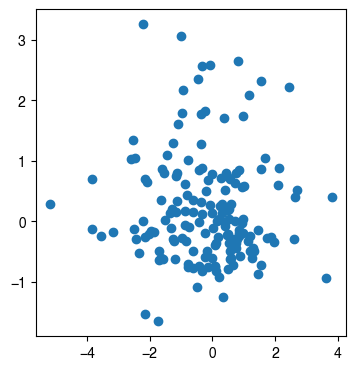

In [34]:
kin1_m = merged[merged['gene_name_h'].isin(list(MBES_targ[MBES_targ['Kinase']==True]['gene_name_h']))]

#kin1_m = kin1_m[kin1_m['target_base_edit_perc']>=10]

x = kin1_m['LFC_KO']
y = kin1_m['LFC_Spleen']

fig, ax = plt.subplots(figsize=(4,4.25))
ax.scatter(x,y)
scipy.stats.spearmanr(x,y)

In [324]:
subset[subset['Type']=='BE']

,gRNA_id,Gene,LFC_Spleen,LFC_bone,LFC_meninges,LFC_d15,Type,mutation_idx,gene_name_h,gene_id_h,...,FDR_Meninges,Z_In Vitro D15,Z_Bone,Z_Spleen,Z_Meninges,sensor_reads,corr_perc,target_base_edit_perc,byproduct_INDEL_perc,byproduct_sub_perc
1543,gRNA_1552,NaN,-0.93885,NaN,NaN,NaN,BE,1271,BRAF,ENSG00000157764.8,...,0.99179,-2.272521,-0.666601,-1.070053,-1.196324,2575.0,51.728155,78.757282,3.883495,34.640777
2205,gRNA_2215,NaN,-1.82070,NaN,NaN,NaN,BE,1840,CREBBP,ENSG00000005339.8,...,0.99179,1.007965,-1.659880,-2.002003,-1.522538,1635.0,74.311927,83.058104,0.366972,9.174312
2230,gRNA_2240,NaN,-1.99430,NaN,NaN,NaN,BE,1863,CREBBP,ENSG00000005339.8,...,0.69083,0.651372,-2.704084,-2.185465,-3.118497,2342.0,91.759180,95.858241,0.042699,4.910333
2444,gRNA_2458,NaN,-2.65220,NaN,NaN,NaN,BE,2045,CTNNB1,ENSG00000168036.12,...,0.99179,-1.415501,-1.852981,-2.880742,-1.412943,575.0,50.086957,51.130435,0.173913,1.739130
4119,gRNA_4141,NaN,-2.80170,NaN,NaN,NaN,BE,3527,FBXW7,ENSG00000109670.9,...,0.99179,-1.259022,-2.745286,-3.038735,-1.679926,2393.0,4.554952,92.645215,0.125366,86.585875
4121,gRNA_4143,NaN,-0.65014,NaN,NaN,NaN,BE,3528,FBXW7,ENSG00000109670.9,...,0.99179,-0.171079,0.214960,-0.764941,-0.486419,2511.0,28.315412,94.305058,0.000000,66.069295
9795,gRNA_9838,NaN,-1.08540,NaN,NaN,NaN,BE,8110,PTPRD,ENSG00000153707.11,...,0.99263,-0.092780,-0.920843,-1.224929,0.684663,1037.0,22.757956,67.116683,0.000000,54.676953
10525,gRNA_10574,NaN,-0.64894,NaN,NaN,NaN,BE,8771,RECQL,ENSG00000004700.11,...,0.99179,-0.332341,-0.233000,-0.763673,-0.419722,3379.0,76.975437,83.012726,0.059189,6.806748
10574,gRNA_10623,NaN,-1.99210,NaN,NaN,NaN,BE,8813,RHOA,ENSG00000067560.6,...,0.99179,-1.470638,-3.031344,-2.183140,-1.317623,1805.0,29.196676,78.005540,0.000000,49.916898
12950,gRNA_13007,NaN,-6.08180,NaN,NaN,NaN,BE,10754,VHL,ENSG00000134086.7,...,0.99179,-3.785741,-2.923455,-6.505184,-1.381465,202.0,45.544554,99.504950,0.990099,52.970297


In [312]:
subset




['BRAF K601E\nBraf K638E',
 'CREBBP W1502R\nCrebbp W1503R',
 'CREBBP Y1503H\nCrebbp Y1504H',
 'CTNNB1 D32G\nCtnnb1 D32G',
 'FBXW7 W425R\nFbxw7 W428R',
 'FBXW7 H460R\nFbxw7 H463R',
 'PTPRD T456A\nPtprd T456A',
 'RECQL L500P\nRecql L500P',
 'RHOA L57S\nRhoa L57S',
 'VHL N78S\nVhl N44S']

In [311]:
subset

,gRNA_id,Gene,LFC_Spleen,LFC_bone,LFC_meninges,LFC_d15,Type,mutation_idx,gene_name_h,gene_id_h,...,FDR_Meninges,Z_In Vitro D15,Z_Bone,Z_Spleen,Z_Meninges,sensor_reads,corr_perc,target_base_edit_perc,byproduct_INDEL_perc,byproduct_sub_perc
5,gRNA_1552,Braf,3.62680,3.80500,7.10190,1.289400,KO,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,gRNA_9838,Ptprd,3.22760,3.35040,5.16270,-0.311740,KO,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,gRNA_10574,Recql,2.16670,1.50040,0.78308,0.127290,KO,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,gRNA_4143,Fbxw7,2.37270,1.75510,4.10440,0.991790,KO,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,gRNA_10623,Rhoa,1.68950,1.96850,5.14230,0.327590,KO,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130,gRNA_4141,Fbxw7,1.28480,1.08880,-0.80852,0.016685,KO,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,gRNA_2240,Crebbp,1.12030,0.97582,-0.90589,0.048538,KO,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
404,gRNA_13007,Vhl,-2.32540,-4.30550,-6.57080,0.963910,KO,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
509,gRNA_2215,Crebbp,0.80361,0.73032,-0.97084,-0.619200,KO,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
866,gRNA_2458,Ctnnb1,0.21594,-0.29074,-2.57730,-0.312150,KO,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In Vitro D15
1 Arid5b I213T tab:grey
2 Foxo1 M1V tab:purple
3 Lck T497A tab:red
4 Syk N451S tab:red
5 Trp53 M243T tab:purple
732 Vhl N44S tab:blue
733 Kmt2c K1707E tab:blue
734 Fbxw7 W428R tab:blue
735 Ptprd T456A tab:blue
736 Braf K638E tab:red
Spleen
1 Arid5b I213T tab:grey
2 Foxo1 M1V tab:purple
3 Lck T497A tab:red
4 Syk N451S tab:red
5 Trp53 M243T tab:purple
732 Vhl N44S tab:blue
733 Kmt2c K1707E tab:blue
734 Fbxw7 W428R tab:blue
735 Ptprd T456A tab:blue
736 Braf K638E tab:red
Bone
1 Arid5b I213T tab:grey
2 Foxo1 M1V tab:purple
3 Lck T497A tab:red
4 Syk N451S tab:red
5 Trp53 M243T tab:purple
732 Vhl N44S tab:blue
733 Kmt2c K1707E tab:blue
734 Fbxw7 W428R tab:blue
735 Ptprd T456A tab:blue
736 Braf K638E tab:red
Meninges
1 Arid5b I213T tab:grey
2 Foxo1 M1V tab:purple
3 Lck T497A tab:red
4 Syk N451S tab:red
5 Trp53 M243T tab:purple
732 Vhl N44S tab:blue
733 Kmt2c K1707E tab:blue
734 Fbxw7 W428R tab:blue
735 Ptprd T456A tab:blue
736 Braf K638E tab:red


Text(0.5, 1.0, 'Meninges')

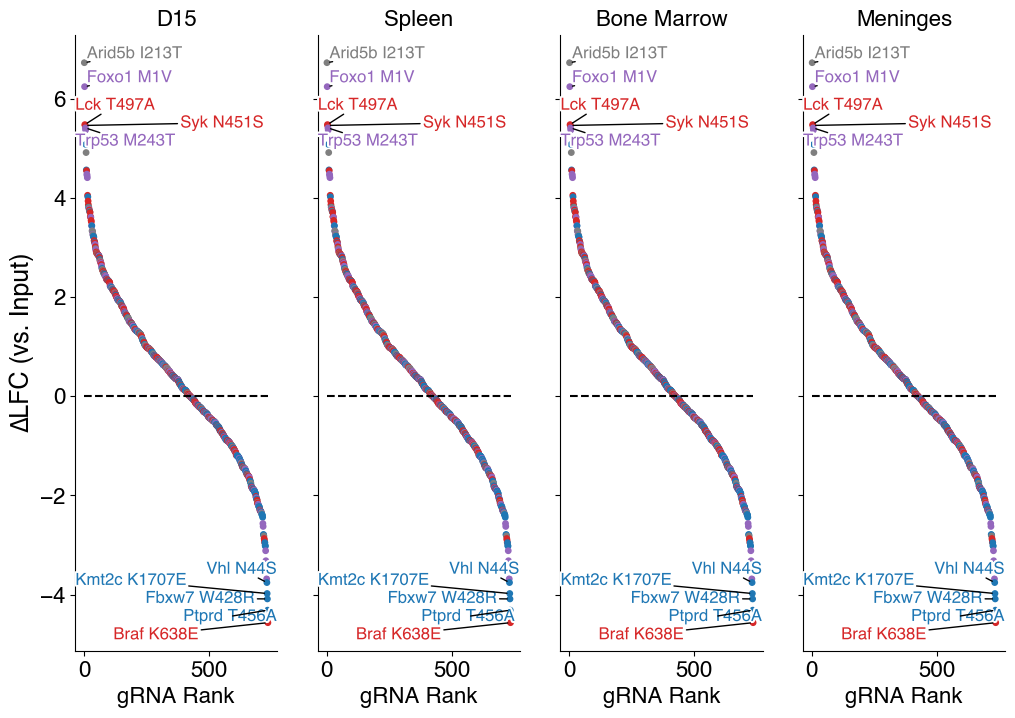

In [264]:
merged = merged.sort_values(by='delta', ascending=False)


from adjustText import adjust_text
import matplotlib.patheffects as PathEffects


min_edit = 50


CBE_targ = merged


#-----and plotting--------
names2 = ['In Vitro D15','Spleen', 'Bone', 'Meninges',]

color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}

fig, ax = plt.subplots(1,4,figsize=(12,8), sharey=True)

for k, val in enumerate(names2):
    #cc = CBE_mageck_dict[val].rename(columns={'sgrna':'gRNA_id'})
    #cc2 = pd.merge(cc, CBE_targ, on='gRNA_id')
    #cc2 = cc2.sort_values(by='LFC', ascending=False)

    cc2 = CBE_targ.sort_values(by=f'delta', ascending=False)

    cc2['Rank'] = range(1, len(cc2)+1)
    cc2['color'] = [color_dict[i] for i in cc2['Role in Cancer']]

    ax[k].scatter(cc2['Rank'], cc2[f'delta'],color=cc2['color'], s=15)

    ax[k].spines[['top', 'right']].set_visible(False)
    ax[k].tick_params(axis='both', which='major', labelsize=16,)
    ax[k].plot([1, len(cc2)+1], [0,0], linestyle='dashed', color='black')
    ax[k].set_xlabel('gRNA Rank', fontsize=16)

    #and annotate top and bottom 5 variant
    top = cc2[:5]
    bottom = cc2[-5:]
    tb = pd.concat((top, bottom))

    t = []
    x = []
    y = []
    c = []
    print(val)
    for i, val2 in tb.iterrows():
        y.append(val2[f'delta'])
        x.append(val2['Rank'])
        c.append(val2['color'])
        a = val2['HGVSp_m']
        if a=='Not calculated (legacy)':
            a = val2['HGVSp_h'] + ' (human)'
        b = val2['gene_name_m']
        t.append(f'{b} {a}')

        print(f'{val2["Rank"]} {b} {a} {val2["color"]}')

    texts = [ax[k].text(x[i], y[i], t[i], fontsize=12, color=c[i], path_effects=[PathEffects.withStroke(linewidth=3,foreground="w")]) for i in range(len(x))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)

    adjust_text(texts, only_move={'points':'xy', 'texts':'xy'}, ax=ax[k], arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))


#ax.set_ylim(0,20)

ax[0].set_ylabel('∆LFC (vs. Input)', fontsize=18)
ax[0].set_title('D15', fontsize=16)
ax[1].set_title('Spleen', fontsize=16)
ax[2].set_title('Bone Marrow', fontsize=16)
ax[3].set_title('Meninges', fontsize=16)

PearsonRResult(statistic=0.5669274243344884, pvalue=0.0038680094525685585)

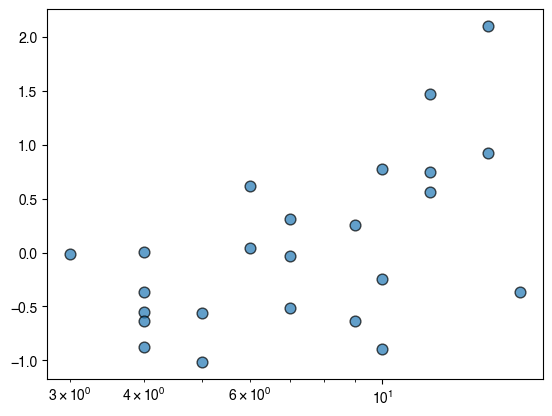

In [160]:
g = 'Tsc2'
tissue = 'LFC_Spleen'
m2 = m1[(m1['gene_name_m']==g) & (m1['target_base_edit_perc']>=50)]
x,y = m2['mutation_count'], m2[tissue]
plt.scatter(x,y, alpha=.7, edgecolor='black', s=60)
plt.xscale('log')
scipy.stats.pearsonr(x,y)

PearsonRResult(statistic=0.5364168496400995, pvalue=0.04798297732977794)

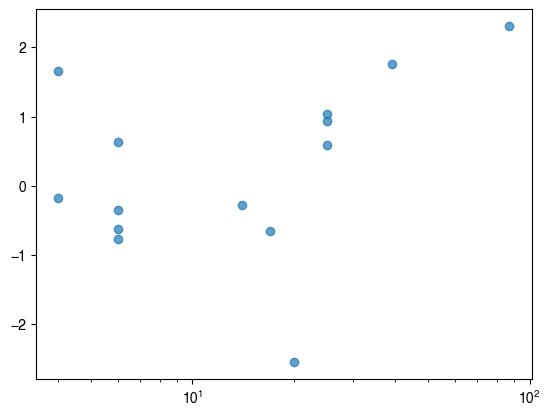

In [106]:
g = 'Ptpn11'
tissue = 'LFC_Meninges'
m2 = m1[(m1['gene_name_m']==g) & (m1['target_base_edit_perc']>=50)]
x,y = m2['mutation_count'], m2[tissue]
plt.scatter(x,y, alpha=.7)
plt.xscale('log')
scipy.stats.pearsonr(x,y)

In [27]:
TSGs = m1[m1['Role in Cancer']=='TSG']
oncogenes = m1[m1['Role in Cancer']=='Oncogene']

u, c= np.unique(TSGs['gene_name_m'], return_counts=True)
dd_TSG = pd.DataFrame(dict(zip(['gene', 'count'], [u,c]))).sort_values(by='count', ascending=False)
top_genes_TSG = list(dd_TSG[dd_TSG['count']>=50]['gene'])


u, c= np.unique(oncogenes['gene_name_m'], return_counts=True)
dd_onco = pd.DataFrame(dict(zip(['gene', 'count'], [u,c]))).sort_values(by='count', ascending=False)
top_genes_onco = list(dd_onco[dd_onco['count']>=50]['gene'])



tissue = 'LFC_Spleen'
edit_cutoff = 20
corr = []
for i in top_genes_onco:
    
    m2 = m1[(m1['gene_name_m']==i) & (m1['target_base_edit_perc']>=edit_cutoff)].sort_values(by='LFC_Bone', ascending=False).reset_index(drop=True)
    
    x,y = m2['mutation_count'], m2[tissue]
    ff = scipy.stats.pearsonr(x,y).statistic
    corr.append(ff)
    print(f'{i}: {ff}')

corr2 = []
for i in top_genes_TSG:
    
    m2 = m1[(m1['gene_name_m']==i) & (m1['target_base_edit_perc']>=edit_cutoff)].sort_values(by='LFC_Bone', ascending=False).reset_index(drop=True)
    
    x,y = m2['mutation_count'], m2[tissue]
    ff = scipy.stats.pearsonr(x,y).statistic
    corr2.append(ff)
    print(f'{i}: {ff}')

Mtor: -0.1250430060897422
Card11: 0.05478130895706144
Pik3ca: -0.07568595365721463
Flt4: -0.07810013646870084
Kmt2a: -0.10469975598210282
Ntrk3: 0.06678361490847998
Brd4: 0.18998839872389714
Alk: 0.20516662879848865
Ar: 0.17809654133608066
Erbb3: -0.04542198171733689
Egfr: 0.039592567499698327
Fgfr2: -0.03557878858314197
Ctnnb1: -0.08466397818894461
Kdr: -0.23035827842046305
Pdgfra: 0.060708907206173994
Pim1: -0.05708512472575682
Ros1: -0.11043746896641031
Pdgfrb: -0.19386878512838243
Erbb2: 0.14613951606342057
Arid1a: 0.16926927842918435
Ptprt: -0.0194156875074806
Smarca4: -0.03387308989186496
Zfhx3: 0.06951111227830858
Grin2a: 0.032845697384045205
Ptprd: 0.17556503661043324
Dnmt3a: 0.08678174657310554
Nf1: 0.13489172905989663
Apc: -0.25783026128266784
Fat1: -0.0956550444966677
Rbm10: 0.14471361914843836
Ep300: 0.0815937732642465
Arid1b: -0.1803299969203967
Keap1: -0.10752685020939601
Atm: -0.14300299955348925
Kmt2c: 0.3380897030941371
Arid2: -0.33818396526237915
Ikzf1: 0.052678188741

(array([2., 1., 3., 3., 5., 9., 7., 1., 2., 1.]),
 array([-0.38447756, -0.29910273, -0.21372789, -0.12835306, -0.04297823,
         0.0423966 ,  0.12777144,  0.21314627,  0.2985211 ,  0.38389594,
         0.46927077]),
 <BarContainer object of 10 artists>)

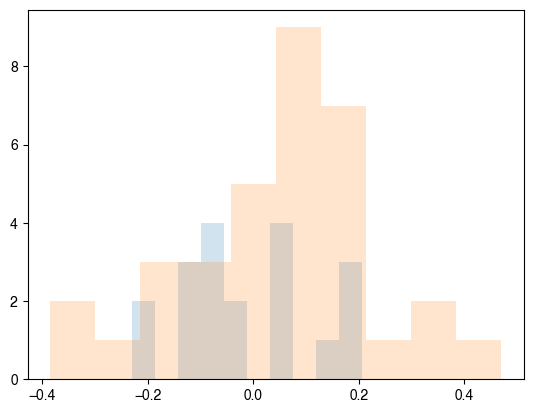

In [28]:
plt.hist(corr, alpha=.2)
plt.hist(corr2, alpha=.2)

In [17]:
top_genes_onco

['Mtor',
 'Card11',
 'Pik3ca',
 'Flt4',
 'Kmt2a',
 'Ntrk3',
 'Brd4',
 'Alk',
 'Ar',
 'Erbb3',
 'Egfr',
 'Fgfr2',
 'Ctnnb1',
 'Kdr',
 'Pdgfra',
 'Pim1',
 'Ros1',
 'Pdgfrb',
 'Erbb2',
 'Foxa1',
 'Prex2',
 'Fgfr3',
 'Smo',
 'Ntrk2',
 'Sf3b1',
 'Met',
 'Ptpn11',
 'Bcl6',
 'Bcl2',
 'Rara',
 'Braf',
 'Stat3',
 'Foxp1',
 'Gata2',
 'Mitf',
 'Fgfr4',
 'Myod1',
 'Ddr2',
 'Erg',
 'Araf',
 'Hgf',
 'Gnas',
 'Fgfr1',
 'Pik3cb',
 'Tcf7l2',
 'Kdm5a',
 'Kit']

In [11]:
u, c= np.unique(m1['gene_name_m'], return_counts=True)
dd = pd.DataFrame(dict(zip(['gene', 'count'], [u,c]))).sort_values(by='count', ascending=False)
top_genes = list(dd[dd['count']>=50]['gene'])

In [4]:
tissue = 'LFC_Spleen'
edit_cutoff = 20
corr = []
for i in top_genes:
    m2 = m1[(m1['gene_name_m']==i) & (m1['target_base_edit_perc']>=edit_cutoff)].sort_values(by='LFC_Bone', ascending=False).reset_index(drop=True)
    
    x,y = m2['mutation_count'], m2[tissue]
    ff = scipy.stats.pearsonr(x,y).statistic
    corr.append(ff)
    print(f'{i}: {ff}')

Kmt2d: -0.059527726474193694
Arid1a: 0.16926927842918435
Ptprt: -0.0194156875074806
Smarca4: -0.03387308989186496
Zfhx3: 0.06951111227830858
Grin2a: 0.032845697384045205
Notch1: 0.13461742992301703
Kmt2b: 0.019550705990881285
Trp53: 0.012228014099807167
Ptprs: -0.0521214394160851
Ptprd: 0.17556503661043324
Dnmt3a: 0.08678174657310554
Nf1: 0.13489172905989663
Crebbp: 0.04649172247712862
Mtor: -0.1250430060897422
Card11: 0.05478130895706144
Notch3: 0.004153983436526494
Apc: -0.25783026128266784
Fat1: -0.0956550444966677
Pik3ca: -0.07568595365721463
Rbm10: 0.14471361914843836
Flt4: -0.07810013646870084
Pik3cg: -0.15451640196340186
Epha7: 0.0868264118785601
Ephb1: 0.3427362864049829
Ep300: 0.0815937732642465
Epha3: -0.38413115733255376
Notch2: 0.0931688983769075
Arid1b: -0.1803299969203967
Kmt2a: -0.10469975598210282
Trp63: 0.07808660342236885
Ntrk3: 0.06678361490847998
Atm: -0.14300299955348925
Keap1: -0.10752685020939601
Epha5: 0.059570566812133297
Kmt2c: 0.3380897030941371
Erbb4: -0.173

SignificanceResult(statistic=0.17093560506924627, pvalue=0.23527288173151228)

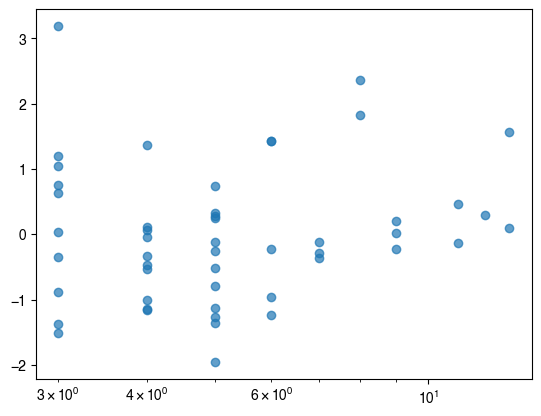

In [5]:
g = 'Brd4'
tissue = 'LFC_Spleen'
m2 = m1[(m1['gene_name_m']==g) & (m1['target_base_edit_perc']>=20)]
x,y = m2['mutation_count'], m2[tissue]
plt.scatter(x,y, alpha=.7)
plt.xscale('log')
scipy.stats.spearmanr(x,y)

(array([ 4.,  2.,  8., 14., 10., 20., 12.,  2.,  5.,  2.]),
 array([-0.38447756, -0.29910273, -0.21372789, -0.12835306, -0.04297823,
         0.0423966 ,  0.12777144,  0.21314627,  0.2985211 ,  0.38389594,
         0.46927077]),
 <BarContainer object of 10 artists>)

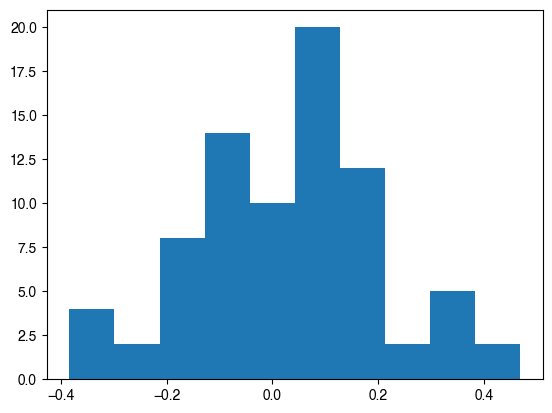

In [168]:
plt.hist(corr)

In [165]:
# looking at if top hit is also most frequent
tissue = 'LFC_Meninges'
edit_cutoff = 20
rank = []
for i in top_genes:
    
    m2 = m1[(m1['gene_name_m']==i) & (m1['target_base_edit_perc']>=20)].sort_values(by='mutation_count', ascending=False).reset_index(drop=True)
    m2['count_rank'] = list(range(1, len(m2)+1))
    m2 = m2.sort_values(by=tissue, ascending=False).reset_index(drop=True)
    m2['LFC_rank'] = list(range(1,  len(m2)+1))
    
    cr = m2.iloc[0]['count_rank']
    print(f'{i}: top hit = {cr}/{len(m2)}')
    rank.append(cr/len(m2))

Kmt2d: top hit = 130/170
Arid1a: top hit = 5/144
Ptprt: top hit = 75/153
Smarca4: top hit = 85/137
Zfhx3: top hit = 10/106
Grin2a: top hit = 47/112
Notch1: top hit = 14/105
Kmt2b: top hit = 14/98
Trp53: top hit = 97/104
Ptprs: top hit = 78/89
Ptprd: top hit = 23/98
Dnmt3a: top hit = 18/92
Nf1: top hit = 47/79
Crebbp: top hit = 49/85
Mtor: top hit = 49/86
Card11: top hit = 41/94
Notch3: top hit = 71/84
Apc: top hit = 10/64
Fat1: top hit = 50/68
Pik3ca: top hit = 21/56
Rbm10: top hit = 7/55
Flt4: top hit = 48/53
Pik3cg: top hit = 1/51
Epha7: top hit = 16/41
Ephb1: top hit = 3/61
Ep300: top hit = 23/41
Epha3: top hit = 28/50
Notch2: top hit = 50/63
Arid1b: top hit = 48/54
Kmt2a: top hit = 17/38
Trp63: top hit = 20/54
Ntrk3: top hit = 52/54
Atm: top hit = 36/44
Keap1: top hit = 51/56
Epha5: top hit = 15/45
Kmt2c: top hit = 5/47
Erbb4: top hit = 27/36
Arid2: top hit = 45/48
Ikzf1: top hit = 28/50
Plcg2: top hit = 14/50
Brd4: top hit = 48/50
Med12: top hit = 24/46
Spen: top hit = 24/38
Fbxw7

(array([ 9.,  8.,  6., 10.,  9., 10.,  4.,  9.,  5.,  9.]),
 array([0.01960784, 0.11764706, 0.21568627, 0.31372549, 0.41176471,
        0.50980392, 0.60784314, 0.70588235, 0.80392157, 0.90196078,
        1.        ]),
 <BarContainer object of 10 artists>)

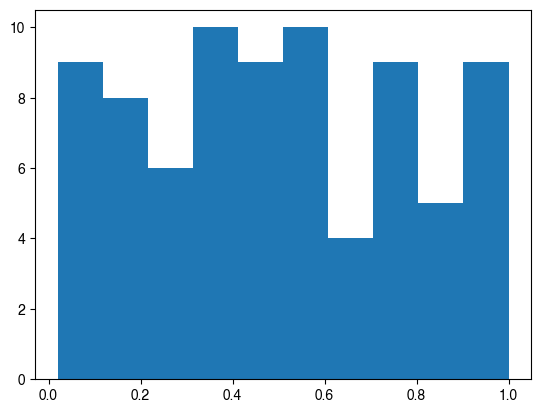

In [166]:
plt.hist(rank)

In [95]:
master = pd.read_csv('master_table_min50_control_mean_invitro.csv')
master[(master['classification']=='targeting guide') & (master['legacy']==False)]

,gRNA_id,mutation_idx,gene_name_h,gene_id_h,tx_id_h,chr_h,exon_num_h,strand_h,match,start_h,...,FDR_Meninges,Z_In Vitro D15,Z_Bone,Z_Spleen,Z_Meninges,sensor_reads,corr_perc,target_base_edit_perc,byproduct_INDEL_perc,byproduct_sub_perc
0,gRNA_1,0,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11.0,+,True,133730186.0,...,9.917900e-01,-0.405584,-0.726103,-0.886559,-0.629736,1192,1.510067,1.929530,1.761745,28.859060
1,gRNA_3,0,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11.0,+,True,133730186.0,...,9.936400e-01,1.157921,0.335311,-0.197338,0.471493,459,0.217865,0.217865,0.000000,19.825708
2,gRNA_4,3,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11.0,+,True,133760819.0,...,5.496600e-03,-0.746236,0.854400,0.098527,0.628595,1544,13.341969,28.691710,10.492228,32.448187
3,gRNA_5,3,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11.0,+,True,133760819.0,...,8.248400e-01,-0.075177,-0.032860,0.443402,-0.143513,1915,46.997389,73.159269,0.156658,35.718016
4,gRNA_6,4,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11.0,+,True,133759553.0,...,7.604700e-02,-1.160367,-0.438416,-0.562529,-0.700720,5146,18.383210,87.174504,1.943257,76.311698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13197,gRNA_13255,10946,ZFHX3,ENSG00000140836.10,ENST00000268489.5,chr16,9.0,-,True,72993336.0,...,3.489900e-02,-0.212068,-2.204280,-2.301817,-2.697350,449,0.000000,0.445434,3.563474,95.768374
13198,gRNA_13256,10946,ZFHX3,ENSG00000140836.10,ENST00000268489.5,chr16,9.0,-,True,72993336.0,...,4.867900e-01,0.500422,0.271493,-1.009261,-0.543602,846,1.300236,3.546099,1.536643,73.522459
13199,gRNA_13257,10947,ZNRF3,ENSG00000183579.11,ENST00000544604.2,chr22,9.0,+,True,29439321.0,...,5.481700e-01,1.237305,-1.103333,-0.818042,-0.300254,4471,33.012749,93.893983,0.961754,54.529188
13200,gRNA_13258,10947,ZNRF3,ENSG00000183579.11,ENST00000544604.2,chr22,9.0,+,True,29439321.0,...,1.616500e-03,0.060346,0.388511,-0.601596,0.757673,1565,1.853035,83.514377,0.063898,85.239617


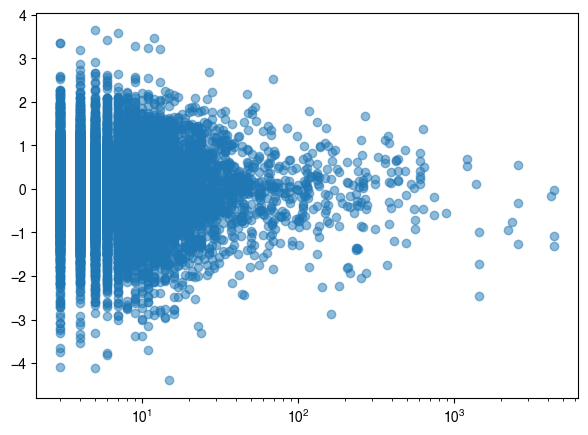

In [135]:
fig, ax = plt.subplots(figsize=(7,5))

x = m1['mutation_count']
y = m1['LFC_In Vitro D15']

ax.scatter(x,y,alpha=.5)
ax.set_xscale('log')

# Nonsense vs. other

In [36]:
c_type = pd.read_csv('cancer_type_counts_per_guide.csv')
total_counts = np.sum(c_type[c_type.columns[:-1]], axis=1)

count_muts = pd.DataFrame(dict(zip(['gRNA_id', 'mutation_count'], [c_type['gRNA_id'], total_counts])))

master = pd.read_csv('master_table_min50_control_mean_invitro.csv')
master_targ = master[(master['classification']=='targeting guide') & (master['legacy']==False)]

m1 = pd.merge(master_targ, count_muts, on='gRNA_id')
#exclude mutations with indexing issues
m1 = m1[m1['mutation_count']!=0]

cosmic = pd.read_csv('source_data/Census_allSun Nov 17 02_26_47 2024.csv').fillna('Undefined')

#MBES = pd.read_csv('MBESv2_CORRECTED.csv')

t_dict = {'TSG':'TSG', 'TSG, fusion':'TSG', 'Undefined':'Undefined', 'fusion':'Undefined', 'oncogene':'Oncogene',
       'oncogene, TSG':'Oncogene/TSG', 'oncogene, TSG, fusion':'Oncogene/TSG', 'oncogene, fusion': 'Oncogene'}

gene_type = []
for i, val in m1.iterrows():
    v = val['gene_name_h']
    subset = cosmic[cosmic['Gene Symbol']==v]
    if len(subset)==0:
        gene_type.append('Undefined')
    else:
        v2 = subset['Role in Cancer'].values[0]

        gene_type.append(t_dict[v2])

m1['Role in Cancer']=gene_type

(array([0.00161094, 0.00322188, 0.00644375, 0.02416407, 0.11437659,
        0.34151883, 0.33668602, 0.14337347, 0.01610938, 0.00322188]),
 array([-5.9682 , -4.95884, -3.94948, -2.94012, -1.93076, -0.9214 ,
         0.08796,  1.09732,  2.10668,  3.11604,  4.1254 ]),
 <BarContainer object of 10 artists>)

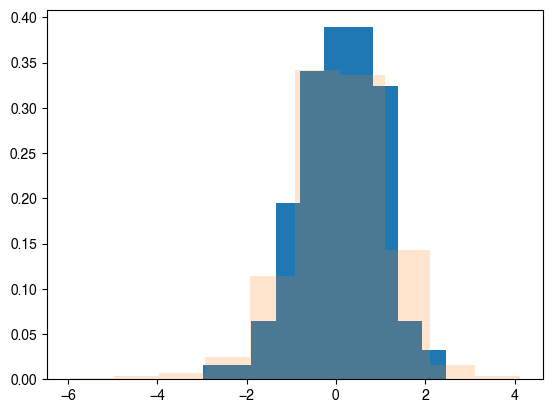

In [48]:
nonsense = m1[m1['classification_h'].isin(['Nonsense', 'Nonsense_mutation'])]
plt.hist(nonsense[(nonsense['Role in Cancer']=='Oncogene') & (nonsense['target_base_edit_perc']>=20)]['LFC_Bone'], density=True)
plt.hist(nonsense[(nonsense['Role in Cancer']=='TSG') & (nonsense['target_base_edit_perc']>=20)]['LFC_Bone'], alpha=.2, density=True)

# Alphamissense

In [2]:
uniprot_mapping = pd.read_csv('source_data/idmapping_2024_11_25.tsv', sep='\t')
reviewed_uniprot = uniprot_mapping[uniprot_mapping['Reviewed']=='reviewed']
reviewed_uniprot

,From,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length
0,ABL1,P00519,reviewed,ABL1_HUMAN,Tyrosine-protein kinase ABL1 (EC 2.7.10.2) (Ab...,ABL1 ABL JTK7,Homo sapiens (Human),1130
11,ACTG1,P63261,reviewed,ACTG_HUMAN,"Actin, cytoplasmic 2 (EC 3.6.4.-) (Gamma-actin...",ACTG1 ACTG,Homo sapiens (Human),375
22,ACVR1,Q04771,reviewed,ACVR1_HUMAN,Activin receptor type-1 (EC 2.7.11.30) (Activi...,ACVR1 ACVRLK2,Homo sapiens (Human),509
34,AGO2,Q9UKV8,reviewed,AGO2_HUMAN,Protein argonaute-2 (Argonaute2) (hAgo2) (EC 3...,AGO2 EIF2C2,Homo sapiens (Human),859
37,AKT1,P31749,reviewed,AKT1_HUMAN,RAC-alpha serine/threonine-protein kinase (EC ...,AKT1 PKB RAC,Homo sapiens (Human),480
...,...,...,...,...,...,...,...,...
24848,YAP1,P46937,reviewed,YAP1_HUMAN,Transcriptional coactivator YAP1 (Yes-associat...,YAP1 YAP65,Homo sapiens (Human),504
24851,YES1,P07947,reviewed,YES_HUMAN,Tyrosine-protein kinase Yes (EC 2.7.10.2) (Pro...,YES1 YES,Homo sapiens (Human),543
24854,YLPM1,P49750,reviewed,YLPM1_HUMAN,YLP motif-containing protein 1 (Nuclear protei...,YLPM1 C14orf170 ZAP3,Homo sapiens (Human),2146
24861,ZFHX3,Q15911,reviewed,ZFHX3_HUMAN,Zinc finger homeobox protein 3 (AT motif-bindi...,ZFHX3 ATBF1 C16orf47,Homo sapiens (Human),3703


In [3]:
reviewed_uniprot[reviewed_uniprot['From']=='GNAS']
#need to deal with these cases

,From,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length
2134,GNAS,O95467,reviewed,GNAS3_HUMAN,Neuroendocrine secretory protein 55 (NESP55) [...,GNAS GNAS1,Homo sapiens (Human),245
2135,GNAS,P63092,reviewed,GNAS2_HUMAN,Guanine nucleotide-binding protein G(s) subuni...,GNAS GNAS1 GSP,Homo sapiens (Human),394
2136,GNAS,P84996,reviewed,ALEX_HUMAN,Protein ALEX (Alternative gene product encoded...,GNAS GNAS1,Homo sapiens (Human),626
2137,GNAS,Q5JWF2,reviewed,GNAS1_HUMAN,Guanine nucleotide-binding protein G(s) subuni...,GNAS GNAS1,Homo sapiens (Human),1037


In [11]:
am = pd.read_csv('/Users/samgould/Desktop/alpha-missense/existing_p53_variant_annotations/AlphaMissense_aa_substitutions.tsv.gz', compression='gzip', header=3, sep='\t')
subset_am = am[am['uniprot_id'].isin(list(reviewed_uniprot['Entry']))]

In [20]:
#easy way of slicing dataset to make it smaller
#results in redundant entries, but significantly pared down
master = pd.read_csv('master_table_unfiltered.csv')
targ = master[master['classification']=='targeting guide']
targ_missense = targ[targ['classification_h']=='Missense']

am_inc = subset_am[subset_am['protein_variant'].isin(targ_missense['HGVSp_h'])]

am_inc

,uniprot_id,protein_variant,am_pathogenicity,am_class
10063757,O00141,M1I,0.4928,ambiguous
10063765,O00141,M1T,0.6444,pathogenic
10063766,O00141,M1V,0.1196,benign
10063898,O00141,A8T,0.0749,benign
10063905,O00141,K9E,0.0755,benign
...,...,...,...,...
215953920,Q9Y6X0,P1557S,0.0805,benign
215954148,Q9Y6X0,P1569S,0.0638,benign
215954451,Q9Y6X0,R1585Q,0.3352,benign
215954455,Q9Y6X0,R1585W,0.5754,pathogenic


In [30]:
ru = reviewed_uniprot.rename(columns = {'Entry':'uniprot_id'})
merged = pd.merge(am_inc, ru, on='uniprot_id')


am_score = []
am_class = []
for i, val in targ_missense.iterrows():
    g = val['gene_name_h']
    hg = val['HGVSp_h']

    subset = merged[(merged['From']==g) & (merged['protein_variant']==hg)]

    if len(subset)>0:
        am_score.append(subset['am_pathogenicity'].values[0])
        am_class.append(subset['am_class'].values[0])
    else:
        am_score.append(None)
        am_class.append(None)



In [31]:
targ_missense['am_pathogenicity'] = am_score
targ_missense['am_class'] = am_class

In [37]:
am_mbes = targ_missense.dropna(subset='am_pathogenicity')

(array([2285., 1164.,  746.,  544.,  505.,  456.,  450.,  513.,  741.,
        3800.]),
 array([0.05 , 0.145, 0.24 , 0.335, 0.43 , 0.525, 0.62 , 0.715, 0.81 ,
        0.905, 1.   ]),
 <BarContainer object of 10 artists>)

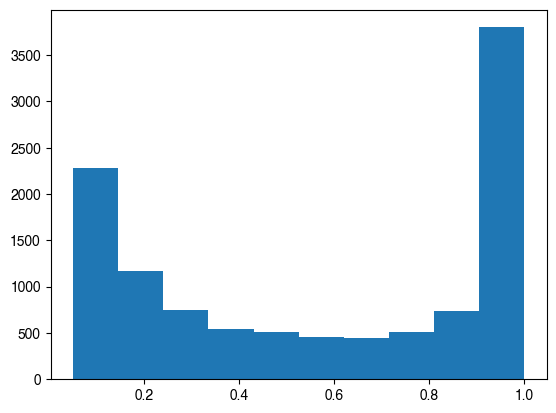

In [39]:
plt.hist(am_mbes['am_pathogenicity'])

<Axes: xlabel='am_class', ylabel='Z_Bone'>

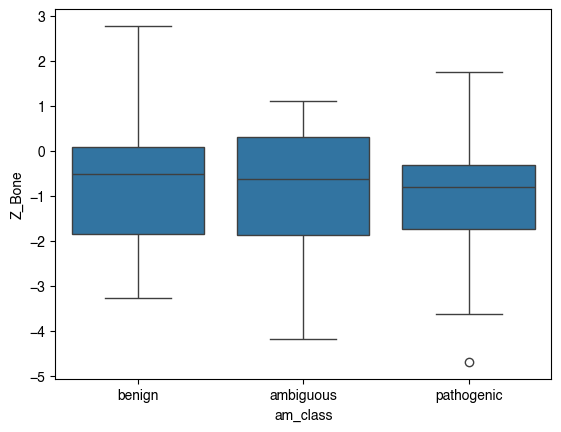

In [137]:
sns.boxplot(data = am_mbes[am_mbes['target_base_edit_perc']>=100], x='am_class', y='Z_Bone', order=['benign', 'ambiguous','pathogenic',])

In [141]:
cosmic = pd.read_csv('source_data/Census_allSun Nov 17 02_26_47 2024.csv').fillna('Undefined')

t_dict = {'TSG':'TSG', 'TSG, fusion':'TSG', 'Undefined':'Undefined', 'fusion':'Undefined', 'oncogene':'Oncogene',
       'oncogene, TSG':'Oncogene/TSG', 'oncogene, TSG, fusion':'Oncogene/TSG', 'oncogene, fusion': 'Oncogene'}

gene_type = []
for i, val in am_mbes.iterrows():
    v = val['gene_name_h']
    subset = cosmic[cosmic['Gene Symbol']==v]
    if len(subset)==0:
        gene_type.append('Undefined')
    else:
        v2 = subset['Role in Cancer'].values[0]

        gene_type.append(t_dict[v2])

am_mbes['Role in Cancer']=gene_type

#am_mbes['Role in cancer']

<Axes: xlabel='am_class', ylabel='Z_Bone'>

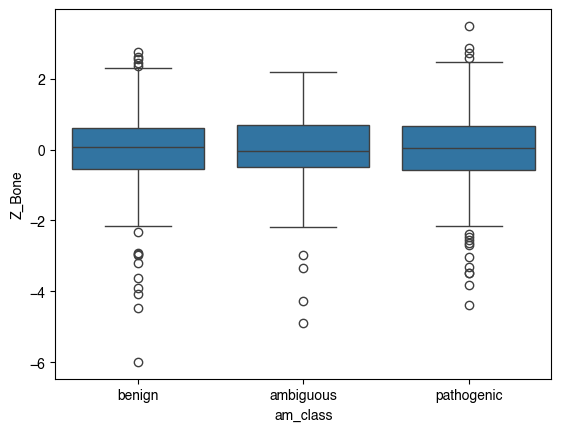

In [149]:
sns.boxplot(data = am_mbes[(am_mbes['target_base_edit_perc']>=0) & (am_mbes['Role in Cancer']=='Oncogene/TSG')], x='am_class', y='Z_Bone', order=['benign', 'ambiguous','pathogenic',])

PearsonRResult(statistic=-0.07761129711713038, pvalue=0.5388788717486285)

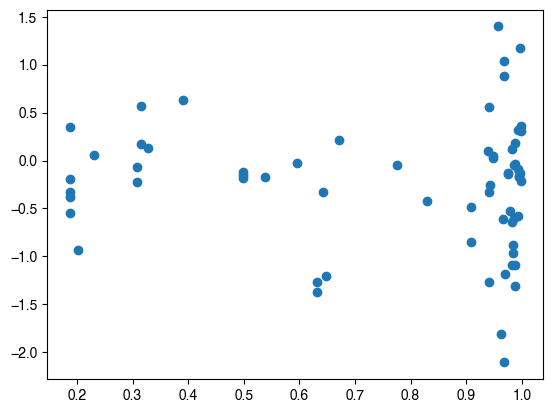

In [121]:
cutoff=10

gene = 'PIK3CA'
sub = am_mbes[(am_mbes['gene_name_h']==gene) & (am_mbes['target_base_edit_perc']>=cutoff)]
x = sub['LFC_In Vitro D15']
y = sub['am_pathogenicity']
plt.scatter(y,x)
scipy.stats.pearsonr(y,x)


In [110]:
u, c= np.unique(am_mbes['gene_name_h'], return_counts=True)
dd = pd.DataFrame(dict(zip(['gene', 'count'], [u,c]))).sort_values(by='count', ascending=False)

cutoff=30


iv = []
sp = []
b = []
m = []

for gene in list(dd['gene'][:70]):

    sub = am_mbes[(am_mbes['gene_name_h']==gene) & (am_mbes['target_base_edit_perc']>=cutoff)]
    #print(gene)
    y = sub['am_pathogenicity']
    for idx, xx in enumerate(['LFC_In Vitro D15', 'LFC_Spleen', 'LFC_Bone', 'LFC_Meninges']):
        
        x = sub[xx]
        aa = scipy.stats.pearsonr(y,x).statistic
        if idx==0:
            iv.append(aa)
        if idx==1:
            sp.append(aa)
        if idx==2:
            b.append(aa)
        if idx==3:
            m.append(aa)

        

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         1.,  2.,  5.,  5.,  9., 10.,  8.,  3.,  5.,  3.,  6.,  2.,  3.,
         2.,  3.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.]),
 array([-1.  , -0.95, -0.9 , -0.85, -0.8 , -0.75, -0.7 , -0.65, -0.6 ,
        -0.55, -0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15,
        -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,
         0.35,  0.4 ,  0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,
         0.8 ,  0.85,  0.9 ,  0.95,  1.  ]),
 <BarContainer object of 40 artists>)

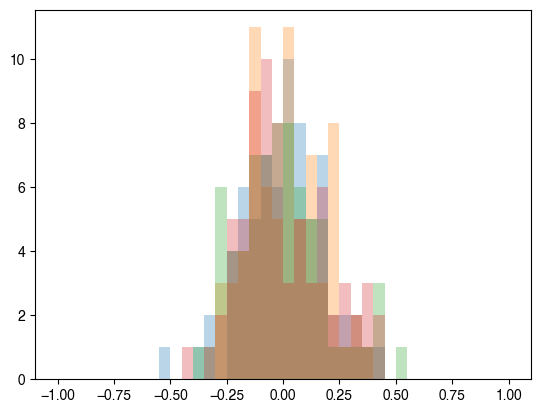

In [111]:
bins = np.linspace(-1,1,41)
plt.hist(iv, bins=bins, alpha=.3, label = 'iv')
plt.hist(sp, bins=bins, alpha=.3, label='sp')
plt.hist(b, bins=bins, alpha=.3, label = 'b')
plt.hist(m, bins=bins, alpha=.3, label='m')

In [113]:
list(dd['gene'][:70])[iv.index(min(iv))]

'KDR'

In [116]:
u, c= np.unique(am_mbes['gene_name_h'], return_counts=True)
dd = pd.DataFrame(dict(zip(['gene', 'count'], [u,c]))).sort_values(by='count', ascending=False)
dd

,gene,count
326,PTPRT,192
385,SMARCA4,173
211,KMT2D,170
169,GRIN2A,151
450,ZFHX3,147
...,...,...
77,CHEK1,1
97,DNAJB1,1
250,MYC,1
253,MYD88,1


In [119]:
cosmic = pd.read_csv('source_data/Census_allSun Nov 17 02_26_47 2024.csv').fillna('Undefined')

t_dict = {'TSG':'TSG', 'TSG, fusion':'TSG', 'Undefined':'Undefined', 'fusion':'Undefined', 'oncogene':'Oncogene',
       'oncogene, TSG':'Oncogene/TSG', 'oncogene, TSG, fusion':'Oncogene/TSG', 'oncogene, fusion': 'Oncogene'}

gene_type = []
for i, val in dd.iterrows():
    v = val['gene']
    subset = cosmic[cosmic['Gene Symbol']==v]
    if len(subset)==0:
        gene_type.append('Undefined')
    else:
        v2 = subset['Role in Cancer'].values[0]

        gene_type.append(t_dict[v2])

dd['Role in Cancer']=gene_type
dd[:20]

,gene,count,Role in Cancer
326,PTPRT,192,TSG
385,SMARCA4,173,TSG
211,KMT2D,170,Oncogene/TSG
169,GRIN2A,151,TSG
450,ZFHX3,147,TSG
325,PTPRS,139,Undefined
324,PTPRD,133,TSG
267,NOTCH1,126,Oncogene/TSG
209,KMT2B,121,Undefined
53,CARD11,113,Oncogene


# Cancer type analysis

In [9]:
master = pd.read_csv('master_table_min50_control_mean_invitro.csv')

master_targ = master[master['classification']=='targeting guide']

In [27]:
c_type = pd.read_csv('cancer_type_counts_per_guide.csv')
c_type

,Adenocarcinoma In Situ,Adrenal Gland Cancer,Adrenocortical Adenoma,Adrenocortical Carcinoma,Ampullary Cancer,Anal Cancer,Angiomatoid Fibrous Histiocytoma,Appendiceal Cancer,B-Lymphoblastic Leukemia/Lymphoma,Biliary Tract Cancer,...,Tubular Adenoma of the Colon,UNKNOWN,Undifferentiated Embryonal Sarcoma of the Liver,Uterine Cancer,Uterine Sarcoma,Vaginal Cancer,Vulvar Carcinoma,Vulvar/Vaginal Cancer,Wilms Tumor,gRNA_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gRNA_1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gRNA_2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gRNA_3
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gRNA_4
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gRNA_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gRNA_13255
13255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gRNA_13256
13256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gRNA_13257
13257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gRNA_13258


In [40]:

c_count = pd.DataFrame(dict(zip(['cancer_type', 'count'], [c_type.columns[:-1], np.sum(c_type[c_type.columns[:-1]], axis=0)]))).reset_index(drop=True).sort_values(by='count', ascending=False)

over_100 = c_count[c_count['count']>=200]

over_100['cancer_type']

25                                Colorectal Cancer
28                               Endometrial Cancer
17                                    Breast Cancer
69                       Non-Small Cell Lung Cancer
58                                         Melanoma
10                                   Bladder Cancer
37                                           Glioma
21                        Cancer of Unknown Primary
30                           Esophagogastric Cancer
54                          Mature B-Cell Neoplasms
71                                   Ovarian Cancer
73                                Pancreatic Cancer
83                                  Prostate Cancer
46                                         Leukemia
92                        Skin Cancer, Non-Melanoma
39                             Hepatobiliary Cancer
96                              Soft Tissue Sarcoma
38                             Head and Neck Cancer
22                                  Cervical Cancer
62          

In [51]:
c_type[list(over_100['cancer_type']) + ['gRNA_id']]

,Colorectal Cancer,Endometrial Cancer,Breast Cancer,Non-Small Cell Lung Cancer,Melanoma,Bladder Cancer,Glioma,Cancer of Unknown Primary,Esophagogastric Cancer,Mature B-Cell Neoplasms,...,Germ Cell Tumor,Gastrointestinal Neuroendocrine Tumor,Bone Cancer,Uterine Sarcoma,Vaginal Cancer,Embryonal Tumor,"Blood Cancer, NOS",T-Lymphoblastic Leukemia/Lymphoma,Adrenocortical Carcinoma,gRNA_id
0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gRNA_1
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gRNA_2
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gRNA_3
3,1.0,0.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gRNA_4
4,1.0,0.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gRNA_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13254,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gRNA_13255
13255,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gRNA_13256
13256,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gRNA_13257
13257,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gRNA_13258


In [70]:
combined = pd.merge(master_targ, c_type, on='gRNA_id')


tops = list(over_100['cancer_type'])

o1 = combined[tops]

normed = o1/np.sum(o1, axis=0)

top_cancer = []
for i in range(len(normed)):
    top_cancer.append(tops[np.argmax(normed.iloc[i])])

combined['top_cancer'] = top_cancer

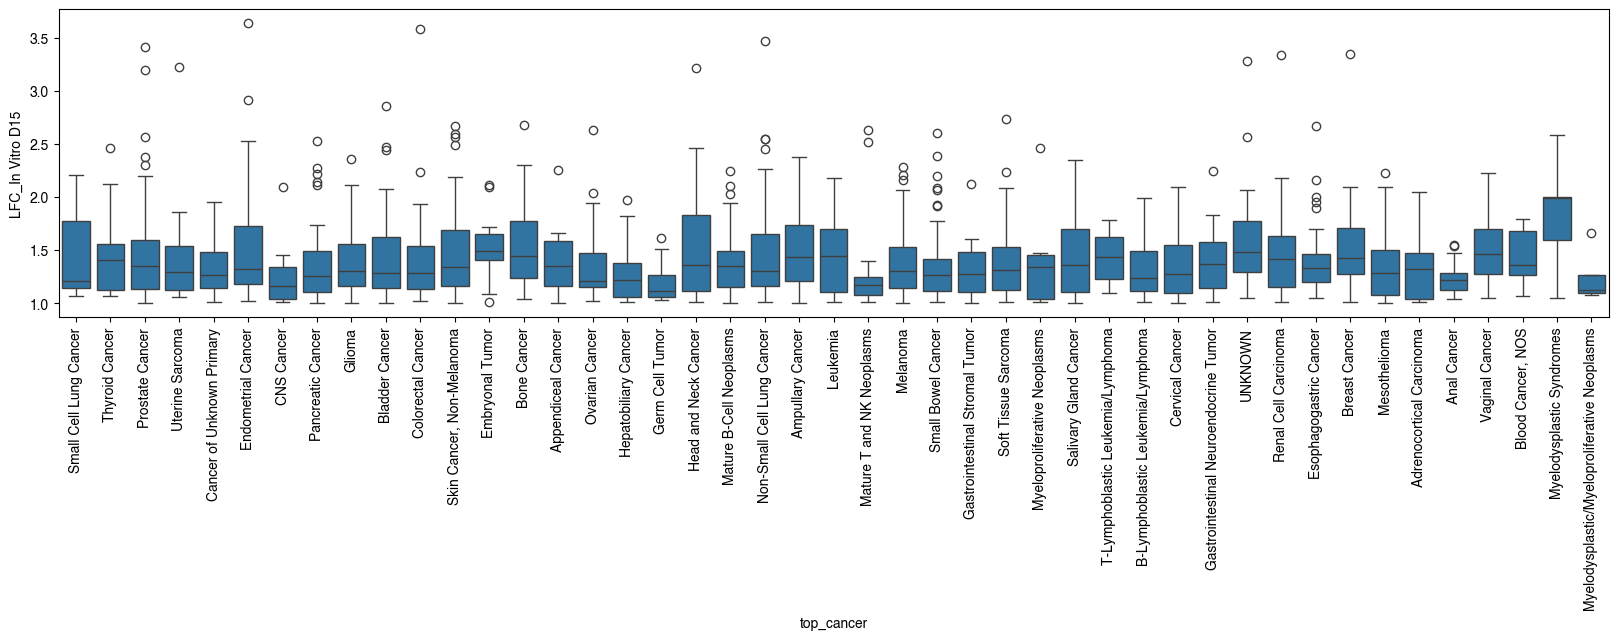

In [80]:
fig, ax = plt.subplots(figsize=(20,4))

tissue = 'LFC_In Vitro D15'
sns.boxplot(data = combined[combined[tissue]>=1], x='top_cancer', y=tissue)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

In [54]:
o1

,Colorectal Cancer,Endometrial Cancer,Breast Cancer,Non-Small Cell Lung Cancer,Melanoma,Bladder Cancer,Glioma,Cancer of Unknown Primary,Esophagogastric Cancer,Mature B-Cell Neoplasms,...,Mesothelioma,Germ Cell Tumor,Gastrointestinal Neuroendocrine Tumor,Bone Cancer,Uterine Sarcoma,Vaginal Cancer,Embryonal Tumor,"Blood Cancer, NOS",T-Lymphoblastic Leukemia/Lymphoma,Adrenocortical Carcinoma
0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13254,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13255,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13256,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13257,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
combined = pd.merge(master_targ, c_type, on='gRNA_id')


pat_cutoff = 2


muts = []


tissue = 'LFC_Bone'

for c in list(over_100['cancer_type']):

    l = combined[combined[c]>=pat_cutoff]
    muts.append(list(l[tissue]))


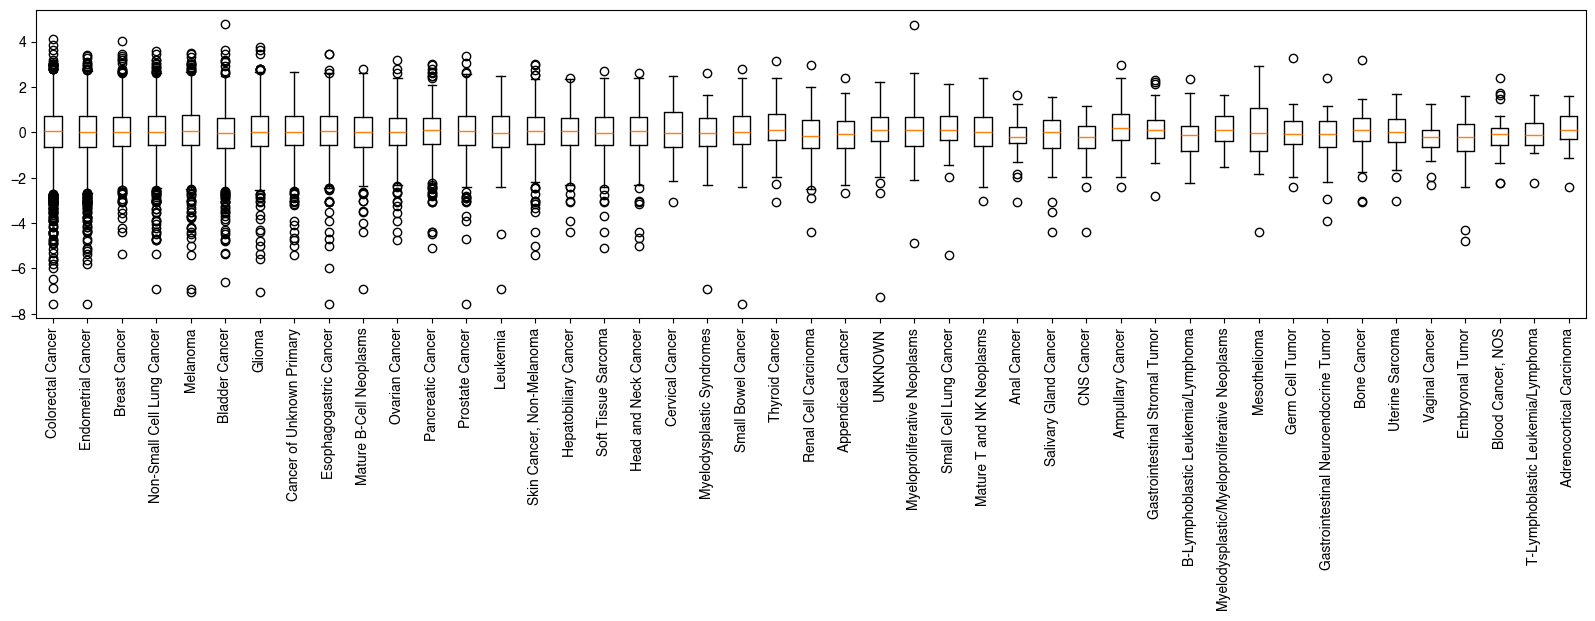

In [47]:
fig, ax = plt.subplots(figsize=(20,4))
plt.boxplot(muts)
ax.set_xticklabels(over_100['cancer_type'], rotation=90);

In [48]:
master_targ.sort_values(by=tissue)

,gRNA_id,mutation_idx,gene_name_h,gene_id_h,tx_id_h,chr_h,exon_num_h,strand_h,match,start_h,...,FDR_Meninges,Z_In Vitro D15,Z_Bone,Z_Spleen,Z_Meninges,sensor_reads,corr_perc,target_base_edit_perc,byproduct_INDEL_perc,byproduct_sub_perc
11439,gRNA_11491,9553,SMARCA4,ENSG00000127616.13,ENST00000344626.4,chr19,34.0,+,True,11132617.0,...,5.402100e-02,-1.220300,-6.601066,-5.579643,-2.815616,433,54.734411,98.845266,0.461894,44.803695
13811,gRNA_13977,MBESv1_legacy_146,EPHA5,NaN,NaN,4,NaN,-,NaN,66270180.0,...,3.162500e-01,-6.011664,-6.377026,-8.659361,-0.820248,0,0.000000,0.000000,0.000000,0.000000
8693,gRNA_8730,7202,PIGA,ENSG00000165195.9,ENST00000333590.4,chrX,5.0,-,True,15349946.0,...,7.915600e-03,-4.098121,-6.359698,-8.477568,-4.136919,160,0.000000,0.000000,0.625000,34.375000
5281,gRNA_5306,4444,IKZF1,ENSG00000185811.12,ENST00000331340.3,chr7,7.0,+,True,50367278.0,...,4.875400e-02,-0.376992,-6.156136,-8.129548,-3.007554,0,0.000000,0.000000,0.000000,0.000000
14108,gRNA_14274,MBESv1_legacy_443,PTPRS,NaN,NaN,19,NaN,-,NaN,5238951.0,...,5.890400e-02,0.279362,-6.129882,-8.510195,-2.361260,0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8435,gRNA_8470,7011,PALB2,ENSG00000083093.5,ENST00000261584.4,chr16,13.0,-,True,23625396.0,...,7.400800e-02,0.994991,3.530707,2.127651,0.784284,1218,2.955665,72.988506,0.164204,91.625616
339,gRNA_341,278,APC,ENSG00000134982.12,ENST00000257430.4,chr5,15.0,+,True,112174223.0,...,1.009000e-02,-0.613177,3.616297,2.034142,0.935761,378,26.190476,76.455026,0.529101,59.259259
12256,gRNA_12312,10178,TEK,ENSG00000120156.16,ENST00000380036.4,chr9,23.0,+,True,27169498.0,...,9.704000e-84,2.998456,3.829048,4.270147,2.803581,1352,0.221893,69.082840,0.000000,98.742604
12109,gRNA_12164,10049,SYK,ENSG00000165025.10,ENST00000375746.1,chr9,13.0,+,True,93640041.0,...,5.292100e-02,3.853779,5.255373,3.367025,1.956047,1351,0.074019,69.504071,0.000000,98.001480


In [81]:
c_type['']

,Adenocarcinoma In Situ,Adrenal Gland Cancer,Adrenocortical Adenoma,Adrenocortical Carcinoma,Ampullary Cancer,Anal Cancer,Angiomatoid Fibrous Histiocytoma,Appendiceal Cancer,B-Lymphoblastic Leukemia/Lymphoma,Biliary Tract Cancer,...,Tubular Adenoma of the Colon,UNKNOWN,Undifferentiated Embryonal Sarcoma of the Liver,Uterine Cancer,Uterine Sarcoma,Vaginal Cancer,Vulvar Carcinoma,Vulvar/Vaginal Cancer,Wilms Tumor,gRNA_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gRNA_1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gRNA_2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gRNA_3
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gRNA_4
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gRNA_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gRNA_13255
13255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gRNA_13256
13256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gRNA_13257
13257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gRNA_13258
